## Topic Modeling

### Approach
1. Tfidf vectorization of transcripts 
2. LDA Topic Modeling
3. NMF Topic Modeling
4. Sentiment analysis by Topics derived from NMF Modeling- Polarity & Subjectivity
5. Regression analysis to understand impact of topics on popularity (measured as number of views)



In [78]:
import pandas as pd
import json

import numpy as np
import matplotlib.pyplot as plt

import pickle 
import re

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
sns.set_style("darkgrid")
from copy import deepcopy

from collections import defaultdict
import operator

%pylab inline

%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from textblob import TextBlob
import nltk
import IPython # we'll use this to draw

In [80]:
with open('../Data/DataDF.pkl', 'rb') as picklefile:
    Data2 = pickle.load(picklefile)

In [81]:
Data2.head()

,id,speaker,headline,URL,description,transcript_URL,month_filmed,year_filmed,event,duration,date_published,views_as_of_06162017,tags,transcript,Pub_Year,Pub_Month
0,1.0,Al Gore,Averting the climate crisis,http://www.ted.com/talks/view/id/1,With the same humor and humanity he exuded in ...,http://www.ted.com/talks/view/id/1/transcript?...,2.0,2006.0,TED2006,0:16:17,2006-06-27,3177001.0,"cars,alternative energy,culture,politics,scien...","Thank you so much, Chris. And it's truly a gre...",2006,6
1,2.0,Amy Smith,Simple designs to save a life,http://www.ted.com/talks/view/id/2,Fumes from indoor cooking fires kill more than...,http://www.ted.com/talks/view/id/2/transcript?...,2.0,2006.0,TED2006,0:15:06,2006-08-15,1379328.0,"MacArthur grant,simplicity,industrial design,a...","In terms of invention, I'd like to tell you th...",2006,8
2,3.0,Ashraf Ghani,How to rebuild a broken state,http://www.ted.com/talks/view/id/3,Ashraf Ghani's passionate and powerful 10-minu...,http://www.ted.com/talks/view/id/3/transcript?...,7.0,2005.0,TEDGlobal 2005,0:18:45,2006-10-18,790536.0,"corruption,poverty,economics,investment,milita...","A public, Dewey long ago observed, is constitu...",2006,10
3,4.0,Burt Rutan,The real future of space exploration,http://www.ted.com/talks/view/id/4,"In this passionate talk, legendary spacecraft ...",http://www.ted.com/talks/view/id/4/transcript?...,2.0,2006.0,TED2006,0:19:37,2006-10-25,1985119.0,"aircraft,flight,industrial design,NASA,rocket ...","I want to start off by saying, Houston, we hav...",2006,10
4,5.0,Chris Bangle,Great cars are great art,http://www.ted.com/talks/view/id/5,American designer Chris Bangle explains his ph...,http://www.ted.com/talks/view/id/5/transcript?...,2.0,2002.0,TED2002,0:20:04,2007-04-05,859487.0,"cars,industrial design,transportation,inventio...","What I want to talk about is, as background, i...",2007,4


#### Finding the Max & Min Viewership for Top & Bottom 25

In [385]:
with open('../Data/Top25.pkl', 'rb') as picklefile2:
    Top25 = pickle.load(picklefile2)

In [386]:
Top25

,id,speaker,headline,URL,description,transcript_URL,month_filmed,year_filmed,event,duration,date_published,views_as_of_06162017,tags,transcript,Pub_Year,Pub_Month
61,66.0,Ken Robinson,Do schools kill creativity?,http://www.ted.com/talks/view/id/66,Sir Ken Robinson makes an entertaining and pro...,http://www.ted.com/talks/view/id/66/transcript...,2.0,2006.0,TED2006,0:19:24,2006-06-27,45622906.0,"dance,education,culture,parenting,children,tea...","Good morning. How are you? It's been great, ha...",2006,6
1260,1569.0,Amy Cuddy,Your body language shapes who you are,http://www.ted.com/talks/view/id/1569,"Body language affects how others see us, but i...",http://www.ted.com/talks/view/id/1569/transcri...,6.0,2012.0,TEDGlobal 2012,0:21:02,2012-10-01,41505006.0,"TED Brain Trust,success,body language,psycholo...",So I want to start by offering you a free no-t...,2012,10
650,848.0,Simon Sinek,How great leaders inspire action,http://www.ted.com/talks/view/id/848,Simon Sinek has a simple but powerful model fo...,http://www.ted.com/talks/view/id/848/transcrip...,9.0,2009.0,TEDxPuget Sound,0:18:04,2010-05-04,32664300.0,"success,TEDx,leadership,entrepreneur,business",How do you explain when things don't go as we ...,2010,5
801,1042.0,BrenÌ© Brown,The power of vulnerability,http://www.ted.com/talks/view/id/1042,BrenÌ© Brown studies human connection -- our a...,http://www.ted.com/talks/view/id/1042/transcri...,6.0,2010.0,TEDxHouston,0:20:19,2010-12-23,29931236.0,"depression,mental health,psychology,self,TEDx,...","So, I'll start with this: a couple years ago, ...",2010,12
438,549.0,Mary Roach,10 things you didn't know about orgasm,http://www.ted.com/talks/view/id/549,"""Bonk"" author Mary Roach delves into obscure s...",http://www.ted.com/talks/view/id/549/transcrip...,2.0,2009.0,TED2009,0:16:43,2009-05-20,21902550.0,"sex,books,culture,history,science,humor,writing",Alright. I'm going to show you a couple of ima...,2009,5
201,229.0,Jill Bolte Taylor,My stroke of insight,http://www.ted.com/talks/view/id/229,Jill Bolte Taylor got a research opportunity f...,http://www.ted.com/talks/view/id/229/transcrip...,2.0,2008.0,TED2008,0:18:19,2008-03-12,20643201.0,"consciousness,illness,biology,brain,science,gl...",I grew up to study the brain because I have a ...,2008,3
89,96.0,Tony Robbins,Why we do what we do,http://www.ted.com/talks/view/id/96,"Tony Robbins discusses the ""invisible forces"" ...",http://www.ted.com/talks/view/id/96/transcript...,2.0,2006.0,TED2006,0:21:45,2006-06-27,19981744.0,"goal-setting,psychology,motivation,culture,pot...",Thank you. I have to tell you I'm both challen...,2006,6
1696,2034.0,Julian Treasure,How to speak so that people want to listen,http://www.ted.com/talks/view/id/2034,"Have you ever felt like you're talking, but no...",http://www.ted.com/talks/view/id/2034/transcri...,6.0,2013.0,TEDGlobal 2013,0:09:58,2014-06-27,19512254.0,"sound,culture,speech",The human voice: It's the instrument we all pl...,2014,6
1333,1647.0,Cameron Russell,"Looks aren't everything. Believe me, I'm a model.",http://www.ted.com/talks/view/id/1647,"Cameron Russell admits she won ""a genetic lott...",http://www.ted.com/talks/view/id/1647/transcri...,10.0,2012.0,TEDxMidAtlantic,0:09:37,2013-01-16,18809201.0,"fashion,photography,TEDx,culture,beauty","Hi. My name is Cameron Russell, and for the la...",2013,1
485,618.0,Dan Pink,The puzzle of motivation,http://www.ted.com/talks/view/id/618,Career analyst Dan Pink examines the puzzle of...,http://www.ted.com/talks/view/id/618/transcrip...,7.0,2009.0,TEDGlobal 2009,0:18:36,2009-08-24,18253944.0,"brain,motivation,social change,science,work,cr...",I need to make a confession at the outset here...,2009,8


In [387]:
Top25['views_as_of_06162017'].max()

45622906.0

In [388]:
Top25['views_as_of_06162017'].min()

12369304.0

In [389]:
with open('../Data/Bottom25.pkl', 'rb') as picklefile3:
     Bottom25 = pickle.load(picklefile3)

In [390]:
Bottom25['views_as_of_06162017'].max()

267626.0

In [391]:
Bottom25['views_as_of_06162017'].min()

138915.0

Adding a Column in DF indicating group Top25 or Bottom25

In [392]:
Top25['PopGroup']='Top25'

In [393]:
Bottom25['PopGroup']='Bottom25' 

Concatenating the Top & Botom Df

In [394]:
TopBotDF = pd.concat([Top25,Bottom25])

In [395]:
TopBotDF.shape

(50, 17)

Use the above Dataframe to add a Column for Topic assigned to each talk by NMF22, later in this notebook

# Transcripts Analysis

## TfidfVectorizer







**Term Frequency (Tf):**  
How many times a particular word appears in a single doc. To understand it better lets take a word : “the”
This word is quite common and would appear with high frequency in all our docs. But if we think about it, “the” does not give any extra info about my doc.
But if we talk about the word “messi”, it give us a context. We can say with some certainty that the doc may be about football. So we need to reduce the weightage of “the” somehow…
Now you may say we can take a reciprocal of their respective frequencies to give more weight to “messi”. Well, close but there is a catch.
There may exist very rare words in our doc. For example : “floccinaucinihilipilification”. It is a real word which means : “The action or habit of estimating something as worthless.”
Now if we use reciprocal for this word, it would certainly be close to 1 but again does not tell us about the context.
So, (taking numbers for example)  

tf (“the”) = 100  
tf(“messi”) = 5  
tf(“floccinaucinihilipilification”) = 1    


**Inverse Document Frequency (idf):**  
The above problem of frequent and rare words is solved by adding this term. So what is it?
It is calculated by taking the log of {number of docs in your corpus divided by the number of docs in which this term appears}. 
So for “the”, the ratio will be close to 1. Therefore, the log will take this to 0.  


idf (“the”) = 0  
idf (“messi”) = log(10/3) = 0.52 (Since corpus is about football)  
idf (“floccinaucinihilipilification”) = log(10/1) = 1  
   
   






  



In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [85]:
Transcripts = Data2['transcript']

In [86]:
Transcripts[:2]

0    Thank you so much, Chris. And it's truly a gre...
1    In terms of invention, I'd like to tell you th...
Name: transcript, dtype: object

In [87]:
from nltk.corpus import stopwords
stop = stopwords.words('english')  #stop stores a list of stopwords in English language
stop += ['.', ',', '(', ')', "'", '"','audience','also','ago','around','actually','aint','arent','around','bit','back',\
        'came','come',\
        'cant','could','called','couldnt','didnt','different','dont','done','every','even','better','fine','first',\
         'go','good','great',\
        'give','going',\
        'got','get','lot','theyre','theres','tell','things','let','little','left','look','use','basically','using',\
         'yeah',\
        'get','hadnt','havent','important','iam','im','isnt','know','like','many','might','mightnt','mustnt','much',\
         'new',\
        'never','oh','ok','okay','put','people','neednt','said','say','says','shant','something','somethings','self',\
        'shouldnt','real',\
        'stuff','see',\
        'take',\
         'thing','think','time',\
        'thanks','thank','thats','us','well','went','want','wasnt','werent','would','wont','youre','wouldnt','really',\
        'one','two',\
        'three','four','five','number','second','third','percent','yes'] 
# adding to the list of stop words
stop = set(stop)  # remove duplicates by using set
stop

{'"',
 "'",
 '(',
 ')',
 ',',
 '.',
 'a',
 'about',
 'above',
 'actually',
 'after',
 'again',
 'against',
 'ago',
 'ain',
 'aint',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 'arent',
 'around',
 'as',
 'at',
 'audience',
 'back',
 'basically',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'better',
 'between',
 'bit',
 'both',
 'but',
 'by',
 'called',
 'came',
 'can',
 'cant',
 'come',
 'could',
 'couldn',
 'couldnt',
 'd',
 'did',
 'didn',
 'didnt',
 'different',
 'do',
 'does',
 'doesn',
 'doing',
 'don',
 'done',
 'dont',
 'down',
 'during',
 'each',
 'even',
 'every',
 'few',
 'fine',
 'first',
 'five',
 'for',
 'four',
 'from',
 'further',
 'get',
 'give',
 'go',
 'going',
 'good',
 'got',
 'great',
 'had',
 'hadn',
 'hadnt',
 'has',
 'hasn',
 'have',
 'haven',
 'havent',
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'iam',
 'if',
 'im',
 'important',
 'in',
 'into',
 'is',
 'isn',
 'isnt',


In [88]:
vectorizer2 = TfidfVectorizer(stop_words=stop,analyzer='word',token_pattern="\\b[a-z][a-z]+\\b")

In [89]:
%%time
SpeechTfidf_Vec = vectorizer2.fit_transform(Transcripts)

CPU times: user 3.71 s, sys: 97.9 ms, total: 3.81 s
Wall time: 3.9 s


In [90]:
SpeechTfidf_Vec.shape

(2386, 56226)

In [91]:
SpeechTfidf_Vec[:20,:10].toarray()  #printing frist 10 features/word/token of first 20 documents/speeches

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [92]:
vectorizer2.get_feature_names()[:10]  #first 10 features in the tfidf vector matrix

['aa',
 'aaa',
 'aaaa',
 'aaaaa',
 'aaaaaaaah',
 'aaaaaaaargh',
 'aaaaaaah',
 'aaaaaah',
 'aaaaaas',
 'aaaab']

In [93]:
np.random.choice(vectorizer2.get_feature_names(), 100)  #100 random features in the tfidf vector matrix

array(['professionalize', 'ovotestis', 'ruppin', 'despondency',
       'replenish', 'clitoral', 'upgrading', 'kirsten', 'malaysia',
       'woodson', 'bugles', 'global', 'airstrip', 'awash', 'superhero',
       'mockery', 'chee', 'kumquat', 'hyperpyrexia', 'soul', 'formalized',
       'kleenex', 'crazes', 'medelln', 'skyscraper', 'cephalosporin',
       'repository', 'sick', 'synthesized', 'outcasting', 'elliot',
       'staying', 'partitioned', 'phobic', 'stings', 'gout', 'simulacrum',
       'opencourseware', 'concealing', 'michael', 'velvety', 'commemorate',
       'cooney', 'poorer', 'cohesive', 'susskind', 'evergreen', 'hadron',
       'sloped', 'zoomed', 'politeness', 'intractably', 'hellespointica',
       'unstitch', 'wrought', 'danielle', 'everlasting', 'yolk',
       'absurdly', 'supremacists', 'arguers', 'circumventing',
       'internationale', 'apology', 'driven', 'squabble', 'stylized',
       'weightless', 'liz', 'computer', 'ciasurveillancevan', 'aravena',
       'greek

### LDA Topic Modeling (Latent Dirichlet allocation)

Another transformation from Tfidf vecorizatation into a topic space of lower dimensionality

LDA is a probabilistic extension of LSA (also called multinomial PCA), so LDA’s topics can be interpreted as probability distributions over words. 

A generative statistical model that allows sets of observations(documents) to be explained by unobserved groups(Topics) that explain why some parts of the data are similar.  
For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word in the document is attributable to one of the document's topics. 


In [16]:
#!pip install --upgrade gensim

In [17]:
# gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets

from sklearn.cluster import KMeans
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

### LDA using TFIDFVectorization  

Observation: LDA didn't work well with TFIDF. Topics produced have words with no apparent relation

In [18]:
%%time
# Create the term-document matrix
# Transpose it so the terms/words/tokens are the rows ...Required for Gensim/LDA
TVec_TFIDF_Speech = vectorizer2.transform(Transcripts).transpose()

CPU times: user 3.35 s, sys: 35.8 ms, total: 3.38 s
Wall time: 3.39 s


In [19]:
TVec_TFIDF_Speech.shape

(56226, 2386)

Convert to gensim  
We need to convert our sparse scipy matrix to a gensim-friendly object called a Corpus:



In [20]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(TVec_TFIDF_Speech)

Map matrix rows to words (tokens)  
We need to save a mapping (dict) of row id to word (token) for later use by gensim:      
(dictionary to map row no./id to word/token)

In [21]:
id2word = dict((v, k) for k, v in vectorizer2.vocabulary_.items())

In [22]:
len(id2word)

56226

## LDA modeling  
It requires our corpus of word counts, mapping of row ids to words, and the number of topics (20).


#### Model 1

**lda1**  

passes = 5 seems to provide better results than passes = 10 in lda2 below

In [58]:
%%time
# Create lda model (equivalent to "fit" in sklearn)
lda1 = models.LdaModel(corpus=corpus, num_topics=20, id2word=id2word, passes=5)

2017-11-04 21:58:15,082 : INFO : using symmetric alpha at 0.05
2017-11-04 21:58:15,085 : INFO : using symmetric eta at 1.77853662007e-05
2017-11-04 21:58:15,100 : INFO : using serial LDA version on this node
2017-11-04 21:58:26,303 : INFO : running online (multi-pass) LDA training, 20 topics, 5 passes over the supplied corpus of 2386 documents, updating model once every 2000 documents, evaluating perplexity every 2386 documents, iterating 50x with a convergence threshold of 0.001000
2017-11-04 21:58:26,304 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-11-04 21:58:26,736 : INFO : PROGRESS: pass 0, at document #2000/2386
2017-11-04 21:58:35,011 : INFO : merging changes from 2000 documents into a model of 2386 documents
2017-11-04 21:58:35,294 : INFO : topic #3 (0.050): 0.001*"world" + 0.001*"make" + 0.001*"way" + 0.001*"years" + 0.001*"data" + 0.000*"right" + 0.000*"need" + 0.000*"work" + 0.000*"k

2017-11-04 21:59:33,113 : INFO : topic #1 (0.050): 0.002*"world" + 0.002*"years" + 0.002*"way" + 0.001*"life" + 0.001*"women" + 0.001*"right" + 0.001*"human" + 0.001*"make" + 0.001*"kids" + 0.001*"work"
2017-11-04 21:59:33,116 : INFO : topic #16 (0.050): 0.003*"brain" + 0.002*"music" + 0.002*"ca" + 0.001*"cancer" + 0.001*"cells" + 0.001*"dance" + 0.001*"tumor" + 0.001*"robot" + 0.001*"sound" + 0.001*"ai"
2017-11-04 21:59:33,120 : INFO : topic #12 (0.050): 0.002*"lt" + 0.001*"titan" + 0.001*"amyloid" + 0.001*"nl" + 0.001*"camel" + 0.001*"exams" + 0.001*"aquaculture" + 0.001*"rollercoaster" + 0.000*"camels" + 0.000*"propeller"
2017-11-04 21:59:33,127 : INFO : topic diff=0.352586, rho=0.488357
2017-11-04 21:59:33,408 : INFO : PROGRESS: pass 3, at document #2000/2386
2017-11-04 21:59:36,166 : INFO : merging changes from 2000 documents into a model of 2386 documents
2017-11-04 21:59:36,457 : INFO : topic #6 (0.050): 0.000*"uber" + 0.000*"extroverts" + 0.000*"introverts" + 0.000*"donna" + 0.

CPU times: user 1min 51s, sys: 1.29 s, total: 1min 53s
Wall time: 1min 54s


**20 Topics**  
Here are the 10 most important words for each of the 20 topics in terms of probability of their occurance in each topic  

Format of LDA Topics Below  
Topic #No. : Prob Word_1 * "Word_1" + Prob Word_2 * "Word_2" + ........+Prob Word_N * "Word_N" 
For each topic, words are ordered starting from the highest probability to the decreasing order of probabilities

In [59]:
lda1.print_topics()

2017-11-04 22:11:56,580 : INFO : topic #0 (0.050): 0.001*"ligo" + 0.001*"lorenzetti" + 0.001*"birch" + 0.001*"boiling" + 0.001*"liminal" + 0.001*"telescopes" + 0.000*"caroline" + 0.000*"nanoscale" + 0.000*"malware" + 0.000*"hydrothermal"
2017-11-04 22:11:56,584 : INFO : topic #1 (0.050): 0.002*"world" + 0.002*"years" + 0.002*"way" + 0.002*"women" + 0.002*"life" + 0.001*"right" + 0.001*"human" + 0.001*"make" + 0.001*"work" + 0.001*"kids"
2017-11-04 22:11:56,586 : INFO : topic #2 (0.050): 0.001*"bitcoin" + 0.001*"dreyfus" + 0.001*"bot" + 0.001*"ynh" + 0.001*"lotus" + 0.001*"walkable" + 0.001*"mb" + 0.001*"investigator" + 0.000*"shootings" + 0.000*"gigawatts"
2017-11-04 22:11:56,589 : INFO : topic #3 (0.050): 0.001*"pancreatic" + 0.001*"aed" + 0.001*"nanoparticle" + 0.001*"nanoparticles" + 0.000*"josephine" + 0.000*"reactors" + 0.000*"seizures" + 0.000*"testify" + 0.000*"violets" + 0.000*"brady"
2017-11-04 22:11:56,592 : INFO : topic #4 (0.050): 0.001*"kenema" + 0.000*"yolo" + 0.000*"grad

[(0,
  '0.001*"ligo" + 0.001*"lorenzetti" + 0.001*"birch" + 0.001*"boiling" + 0.001*"liminal" + 0.001*"telescopes" + 0.000*"caroline" + 0.000*"nanoscale" + 0.000*"malware" + 0.000*"hydrothermal"'),
 (1,
  '0.002*"world" + 0.002*"years" + 0.002*"way" + 0.002*"women" + 0.002*"life" + 0.001*"right" + 0.001*"human" + 0.001*"make" + 0.001*"work" + 0.001*"kids"'),
 (2,
  '0.001*"bitcoin" + 0.001*"dreyfus" + 0.001*"bot" + 0.001*"ynh" + 0.001*"lotus" + 0.001*"walkable" + 0.001*"mb" + 0.001*"investigator" + 0.000*"shootings" + 0.000*"gigawatts"'),
 (3,
  '0.001*"pancreatic" + 0.001*"aed" + 0.001*"nanoparticle" + 0.001*"nanoparticles" + 0.000*"josephine" + 0.000*"reactors" + 0.000*"seizures" + 0.000*"testify" + 0.000*"violets" + 0.000*"brady"'),
 (4,
  '0.001*"kenema" + 0.000*"yolo" + 0.000*"grads" + 0.000*"carly" + 0.000*"greengrocer" + 0.000*"pottery" + 0.000*"chan" + 0.000*"miasmas" + 0.000*"telos" + 0.000*"castillo"'),
 (5,
  '0.001*"blockchain" + 0.001*"burial" + 0.001*"christopher" + 0.001

**Topic Space Mapping to Speeches/Documents**     
Map speeches to the topic space we need to actually use the LdaModel transformer that we created above, like so:

In [60]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus1 = lda1[corpus]
lda_corpus1

In [61]:
# Store the documents' topic vectors in a list so we can take a peak
lda_docs1 = [doc for doc in lda_corpus1]

Now we can take a look at the document vectors in the topic space, which are measures of the component of each document along each topic. Thus, at most a document vector can have num_topics=20 nonzero components in the topic space, and most have far fewer.


**Interpreting the Output below:**  
A list of Topic Probabilities for the 1st 15 Talks    
Each Talk has an individual list of Topic probabilities  
Within the individual list are a set of tuples..    
Tuples indicate all the Topics that reperesnt the speech/document    
1st element of the tuple indicates the Topic no.  
2nd element of the tuple indicates the Topic Probability for that Topic No. in this speech  

In [62]:
lda_docs1[0:15]

[[(1, 0.43077753953163905),
  (7, 0.35445442585060288),
  (9, 0.092535928750132543),
  (16, 0.054939913278432312),
  (18, 0.021600434921930974)],
 [(1, 0.33350949021661913),
  (7, 0.42297988513039397),
  (13, 0.067885687455746066),
  (16, 0.065520425010068203),
  (17, 0.019391026329005169),
  (18, 0.043459588234197488)],
 [(1, 0.50859500471826791),
  (7, 0.31127865269338317),
  (16, 0.033524149908597006),
  (18, 0.10902256534031272)],
 [(1, 0.41255238432503721),
  (5, 0.078780065094343224),
  (7, 0.39815222581134346),
  (16, 0.045681705825966215),
  (18, 0.015894310009114513)],
 [(1, 0.4363526880463881),
  (7, 0.35746538431132246),
  (9, 0.068047135022330105),
  (16, 0.064158834850082461),
  (17, 0.013031796676580228),
  (18, 0.017491565624264262)],
 [(1, 0.33983212996339468),
  (7, 0.54875634024851938),
  (16, 0.042874454628466396),
  (17, 0.013727157652739097),
  (18, 0.016374064150107254)],
 [(1, 0.36927378802752531),
  (7, 0.36909997060258926),
  (15, 0.079729726828637437),
  (16, 

In [63]:
# Check out the document vectors in the topic space for the first 15 documents
for i in range(len(lda_docs1[0:15])):
    print("\nDocumnet ",i)
    [print(x) for x in lda_docs1[i]]  


Documnet  0
(1, 0.43077753953163905)
(7, 0.35445442585060288)
(9, 0.092535928750132543)
(16, 0.054939913278432312)
(18, 0.021600434921930974)

Documnet  1
(1, 0.33350949021661913)
(7, 0.42297988513039397)
(13, 0.067885687455746066)
(16, 0.065520425010068203)
(17, 0.019391026329005169)
(18, 0.043459588234197488)

Documnet  2
(1, 0.50859500471826791)
(7, 0.31127865269338317)
(16, 0.033524149908597006)
(18, 0.10902256534031272)

Documnet  3
(1, 0.41255238432503721)
(5, 0.078780065094343224)
(7, 0.39815222581134346)
(16, 0.045681705825966215)
(18, 0.015894310009114513)

Documnet  4
(1, 0.4363526880463881)
(7, 0.35746538431132246)
(9, 0.068047135022330105)
(16, 0.064158834850082461)
(17, 0.013031796676580228)
(18, 0.017491565624264262)

Documnet  5
(1, 0.33983212996339468)
(7, 0.54875634024851938)
(16, 0.042874454628466396)
(17, 0.013727157652739097)
(18, 0.016374064150107254)

Documnet  6
(1, 0.36927378802752531)
(7, 0.36909997060258926)
(15, 0.079729726828637437)
(16, 0.10003045749546299

# NMF Topic Modeling

#### NMF - 22 Topics

In [582]:
from sklearn.decomposition import NMF
nmf_model22 = NMF(22)  #specify the no. of topics = n_components
nmf_CountVec22 = nmf_model22.fit_transform(SpeechTfidf_Vec) 

In [583]:
ComponenentMat_nmf22 = nmf_model22.components_
# Print list of words assoc'd with topics
Wordlist = vectorizer2.get_feature_names()
#topic-num is row no./topic no. of matrix and word_wt is weight of different words in the topic no.
for topic_num, word_wt in enumerate(ComponenentMat_nmf22): 
    t = word_wt.argsort()[-10:] #returns top 10 word id/col no./index (ones with highest weights in the topic) 
    print("\nTopic Number {0:d}: ".format(topic_num)) #topic no./row no.
    for index in reversed(t):      #parsing through the top 10 indexes and printing the coresponding word 
        print('Word: ',Wordlist[index], '      NMF Weight: ',ComponenentMat_nmf22[topic_num,index])


Topic Number 0: 
Word:  compassion       NMF Weight:  0.46152734367
Word:  human       NMF Weight:  0.39816641491
Word:  happiness       NMF Weight:  0.378254424495
Word:  way       NMF Weight:  0.370546279506
Word:  right       NMF Weight:  0.337734923493
Word:  life       NMF Weight:  0.33307940986
Word:  language       NMF Weight:  0.312331817869
Word:  social       NMF Weight:  0.311963128264
Word:  kind       NMF Weight:  0.302663648723
Word:  world       NMF Weight:  0.288737431156

Topic Number 1: 
Word:  life       NMF Weight:  0.446748240177
Word:  day       NMF Weight:  0.365375731398
Word:  love       NMF Weight:  0.356404534945
Word:  story       NMF Weight:  0.298566174453
Word:  man       NMF Weight:  0.295747040852
Word:  father       NMF Weight:  0.256459805633
Word:  years       NMF Weight:  0.251948885844
Word:  thought       NMF Weight:  0.25045131772
Word:  wanted       NMF Weight:  0.240336533006
Word:  feel       NMF Weight:  0.236682129009

Topic Number 2: 
Word

Word:  disease       NMF Weight:  0.165370467672
Word:  body       NMF Weight:  0.15292514779
Word:  chemotherapy       NMF Weight:  0.126200885532
Word:  treatment       NMF Weight:  0.126195058822

Topic Number 21: 
Word:  cells       NMF Weight:  1.12949449651
Word:  stem       NMF Weight:  0.416535867198
Word:  cell       NMF Weight:  0.319796636839
Word:  tissue       NMF Weight:  0.190671407611
Word:  body       NMF Weight:  0.175661792882
Word:  organs       NMF Weight:  0.172286215181
Word:  bone       NMF Weight:  0.16506368484
Word:  liver       NMF Weight:  0.13475160125
Word:  heart       NMF Weight:  0.126546582045
Word:  disease       NMF Weight:  0.120963950388


In [584]:
# Print list of Topics assoc'd with each Document/Talk

#Talk_num is row no./Talk no. of matrix and topic_prob is probability of different topics in the talk no.
for Talk_num, topic_prob in enumerate(nmf_CountVec22[:10,:]): 
    t = topic_prob.argsort()[-4:] #returns top 4 Topic id/col no./index (ones with highest probabilities in the Talk) 
    print("\nTalk Number {0:d}: ".format(Talk_num)) #Talk no./row no.
    for index in reversed(t):      #parsing through the top 4 indexes and printing the coresponding Topics 
        #print('Topic: ',index, '      NMF Weight: ',nmf_CountVec[Talk_num,index])
        print('Topic: ',index, '%20s %.4f' % ('NMF Weight:',nmf_CountVec22[Talk_num,index]))
    


Talk Number 0: 
Topic:  12          NMF Weight: 0.1360
Topic:  1          NMF Weight: 0.0348
Topic:  15          NMF Weight: 0.0227
Topic:  4          NMF Weight: 0.0150

Talk Number 1: 
Topic:  19          NMF Weight: 0.0948
Topic:  12          NMF Weight: 0.0672
Topic:  14          NMF Weight: 0.0340
Topic:  15          NMF Weight: 0.0276

Talk Number 2: 
Topic:  15          NMF Weight: 0.1066
Topic:  17          NMF Weight: 0.1013
Topic:  4          NMF Weight: 0.0519
Topic:  12          NMF Weight: 0.0171

Talk Number 3: 
Topic:  14          NMF Weight: 0.0657
Topic:  5          NMF Weight: 0.0521
Topic:  12          NMF Weight: 0.0322
Topic:  15          NMF Weight: 0.0310

Talk Number 4: 
Topic:  14          NMF Weight: 0.0842
Topic:  12          NMF Weight: 0.0608
Topic:  1          NMF Weight: 0.0461
Topic:  8          NMF Weight: 0.0315

Talk Number 5: 
Topic:  16          NMF Weight: 0.3175
Topic:  18          NMF Weight: 0.0340
Topic:  12          NMF Weight: 0.0260
Topic: 

### Adding Topics to DF

#### Assigning the Topic with the highest weight to the Talks

In [585]:
#Talk_num is row no./Talk no. of matrix and topic_prob is weight of different topics in the talk no.
# Creating a list for the Topic No. for each document/talk
DocTopicList22= []
for Talk_num, topic_wt in enumerate(nmf_CountVec22): 
    t = topic_wt.argsort()[-1] #returns top Topic id/col no./index (ones with highest wt. in the Talk) 
    print("\nTalk Number {0:d}: ".format(Talk_num)) #Talk no./row no.
    print('Topic: ',t, '%20s %.4f' % ('NMF Weight:',nmf_CountVec22[Talk_num,t]))
    DocTopicList22.append(t)


Talk Number 0: 
Topic:  12          NMF Weight: 0.1360

Talk Number 1: 
Topic:  19          NMF Weight: 0.0948

Talk Number 2: 
Topic:  15          NMF Weight: 0.1066

Talk Number 3: 
Topic:  14          NMF Weight: 0.0657

Talk Number 4: 
Topic:  14          NMF Weight: 0.0842

Talk Number 5: 
Topic:  16          NMF Weight: 0.3175

Talk Number 6: 
Topic:  14          NMF Weight: 0.1282

Talk Number 7: 
Topic:  8          NMF Weight: 0.1199

Talk Number 8: 
Topic:  12          NMF Weight: 0.1692

Talk Number 9: 
Topic:  20          NMF Weight: 0.0907

Talk Number 10: 
Topic:  19          NMF Weight: 0.0637

Talk Number 11: 
Topic:  20          NMF Weight: 0.2855

Talk Number 12: 
Topic:  8          NMF Weight: 0.0688

Talk Number 13: 
Topic:  14          NMF Weight: 0.1411

Talk Number 14: 
Topic:  7          NMF Weight: 0.1071

Talk Number 15: 
Topic:  19          NMF Weight: 0.1342

Talk Number 16: 
Topic:  16          NMF Weight: 0.1061

Talk Number 17: 
Topic:  11          NMF We

Topic:  14          NMF Weight: 0.1365

Talk Number 215: 
Topic:  2          NMF Weight: 0.2493

Talk Number 216: 
Topic:  14          NMF Weight: 0.0894

Talk Number 217: 
Topic:  17          NMF Weight: 0.0665

Talk Number 218: 
Topic:  15          NMF Weight: 0.2282

Talk Number 219: 
Topic:  1          NMF Weight: 0.0944

Talk Number 220: 
Topic:  10          NMF Weight: 0.1824

Talk Number 221: 
Topic:  20          NMF Weight: 0.0985

Talk Number 222: 
Topic:  10          NMF Weight: 0.2876

Talk Number 223: 
Topic:  1          NMF Weight: 0.0418

Talk Number 224: 
Topic:  15          NMF Weight: 0.1198

Talk Number 225: 
Topic:  19          NMF Weight: 0.0577

Talk Number 226: 
Topic:  19          NMF Weight: 0.0720

Talk Number 227: 
Topic:  14          NMF Weight: 0.0526

Talk Number 228: 
Topic:  16          NMF Weight: 0.0223

Talk Number 229: 
Topic:  19          NMF Weight: 0.2580

Talk Number 230: 
Topic:  18          NMF Weight: 0.1605

Talk Number 231: 
Topic:  14       

Topic:  1          NMF Weight: 0.0922

Talk Number 702: 
Topic:  4          NMF Weight: 0.0497

Talk Number 703: 
Topic:  1          NMF Weight: 0.0578

Talk Number 704: 
Topic:  5          NMF Weight: 0.1715

Talk Number 705: 
Topic:  14          NMF Weight: 0.0774

Talk Number 706: 
Topic:  21          NMF Weight: 0.0969

Talk Number 707: 
Topic:  0          NMF Weight: 0.0688

Talk Number 708: 
Topic:  18          NMF Weight: 0.1033

Talk Number 709: 
Topic:  18          NMF Weight: 0.2046

Talk Number 710: 
Topic:  0          NMF Weight: 0.0524

Talk Number 711: 
Topic:  19          NMF Weight: 0.0804

Talk Number 712: 
Topic:  19          NMF Weight: 0.0955

Talk Number 713: 
Topic:  9          NMF Weight: 0.0803

Talk Number 714: 
Topic:  14          NMF Weight: 0.0299

Talk Number 715: 
Topic:  1          NMF Weight: 0.0451

Talk Number 716: 
Topic:  1          NMF Weight: 0.0611

Talk Number 717: 
Topic:  14          NMF Weight: 0.0792

Talk Number 718: 
Topic:  11          NMF

Topic:  17          NMF Weight: 0.2225

Talk Number 1161: 
Topic:  1          NMF Weight: 0.0620

Talk Number 1162: 
Topic:  6          NMF Weight: 0.0938

Talk Number 1163: 
Topic:  2          NMF Weight: 0.0786

Talk Number 1164: 
Topic:  13          NMF Weight: 0.3798

Talk Number 1165: 
Topic:  12          NMF Weight: 0.2252

Talk Number 1166: 
Topic:  11          NMF Weight: 0.0745

Talk Number 1167: 
Topic:  7          NMF Weight: 0.1118

Talk Number 1168: 
Topic:  14          NMF Weight: 0.0763

Talk Number 1169: 
Topic:  2          NMF Weight: 0.4514

Talk Number 1170: 
Topic:  10          NMF Weight: 0.0932

Talk Number 1171: 
Topic:  14          NMF Weight: 0.0701

Talk Number 1172: 
Topic:  21          NMF Weight: 0.2703

Talk Number 1173: 
Topic:  21          NMF Weight: 0.0515

Talk Number 1174: 
Topic:  0          NMF Weight: 0.0310

Talk Number 1175: 
Topic:  19          NMF Weight: 0.1100

Talk Number 1176: 
Topic:  14          NMF Weight: 0.0862

Talk Number 1177: 
Top

Topic:  0          NMF Weight: 0.0468

Talk Number 1549: 
Topic:  3          NMF Weight: 0.1939

Talk Number 1550: 
Topic:  0          NMF Weight: 0.0401

Talk Number 1551: 
Topic:  15          NMF Weight: 0.0714

Talk Number 1552: 
Topic:  21          NMF Weight: 0.3559

Talk Number 1553: 
Topic:  0          NMF Weight: 0.0506

Talk Number 1554: 
Topic:  13          NMF Weight: 0.1172

Talk Number 1555: 
Topic:  8          NMF Weight: 0.2160

Talk Number 1556: 
Topic:  18          NMF Weight: 0.1294

Talk Number 1557: 
Topic:  9          NMF Weight: 0.0595

Talk Number 1558: 
Topic:  18          NMF Weight: 0.0666

Talk Number 1559: 
Topic:  15          NMF Weight: 0.1165

Talk Number 1560: 
Topic:  1          NMF Weight: 0.0637

Talk Number 1561: 
Topic:  8          NMF Weight: 0.1635

Talk Number 1562: 
Topic:  11          NMF Weight: 0.0893

Talk Number 1563: 
Topic:  1          NMF Weight: 0.0852

Talk Number 1564: 
Topic:  14          NMF Weight: 0.0475

Talk Number 1565: 
Topic:

Topic:  14          NMF Weight: 0.0490

Talk Number 1955: 
Topic:  12          NMF Weight: 0.0330

Talk Number 1956: 
Topic:  0          NMF Weight: 0.0753

Talk Number 1957: 
Topic:  6          NMF Weight: 0.0878

Talk Number 1958: 
Topic:  4          NMF Weight: 0.1161

Talk Number 1959: 
Topic:  7          NMF Weight: 0.1004

Talk Number 1960: 
Topic:  9          NMF Weight: 0.0747

Talk Number 1961: 
Topic:  7          NMF Weight: 0.1394

Talk Number 1962: 
Topic:  1          NMF Weight: 0.0854

Talk Number 1963: 
Topic:  12          NMF Weight: 0.1586

Talk Number 1964: 
Topic:  1          NMF Weight: 0.0932

Talk Number 1965: 
Topic:  17          NMF Weight: 0.0555

Talk Number 1966: 
Topic:  19          NMF Weight: 0.0864

Talk Number 1967: 
Topic:  14          NMF Weight: 0.0401

Talk Number 1968: 
Topic:  10          NMF Weight: 0.0460

Talk Number 1969: 
Topic:  7          NMF Weight: 0.1188

Talk Number 1970: 
Topic:  1          NMF Weight: 0.1350

Talk Number 1971: 
Topic: 

In [586]:
DocTopicList22

[12,
 19,
 15,
 14,
 14,
 16,
 14,
 8,
 12,
 20,
 19,
 20,
 8,
 14,
 7,
 19,
 16,
 11,
 1,
 2,
 1,
 14,
 1,
 14,
 14,
 1,
 11,
 8,
 14,
 4,
 1,
 16,
 8,
 14,
 16,
 21,
 19,
 14,
 10,
 14,
 0,
 2,
 2,
 10,
 14,
 8,
 14,
 12,
 8,
 15,
 1,
 17,
 6,
 17,
 15,
 1,
 8,
 15,
 14,
 7,
 14,
 9,
 16,
 0,
 1,
 9,
 1,
 14,
 1,
 8,
 15,
 14,
 14,
 14,
 15,
 16,
 1,
 9,
 16,
 4,
 6,
 1,
 14,
 18,
 14,
 15,
 17,
 0,
 0,
 0,
 0,
 10,
 1,
 1,
 3,
 2,
 12,
 12,
 8,
 1,
 1,
 0,
 0,
 14,
 21,
 16,
 18,
 14,
 7,
 8,
 14,
 8,
 3,
 18,
 15,
 12,
 14,
 0,
 14,
 11,
 17,
 5,
 21,
 15,
 10,
 19,
 14,
 21,
 1,
 1,
 15,
 15,
 12,
 15,
 15,
 15,
 15,
 1,
 15,
 0,
 18,
 17,
 0,
 13,
 10,
 15,
 15,
 1,
 14,
 8,
 9,
 12,
 17,
 5,
 2,
 12,
 1,
 16,
 3,
 15,
 2,
 1,
 1,
 14,
 0,
 12,
 12,
 10,
 13,
 2,
 1,
 15,
 1,
 0,
 1,
 9,
 14,
 7,
 14,
 18,
 14,
 1,
 9,
 14,
 0,
 12,
 8,
 19,
 8,
 14,
 7,
 2,
 8,
 1,
 5,
 1,
 1,
 10,
 14,
 16,
 14,
 3,
 14,
 8,
 15,
 9,
 0,
 1,
 3,
 10,
 4,
 2,
 10,
 12,
 14,
 2,
 14,
 17,
 15,
 1

In [587]:
speakers = list(Data2['speaker'])
headlines = list(Data2['headline'])
tags = list(Data2['tags'])
views = list(Data2['views_as_of_06162017'])
PubMonths = list(Data2['Pub_Month'])
PubYear = list(Data2['Pub_Year'])
ids = list(Data2['id'])


In [588]:
# Dictionary of talks
Talks22 = { 'Id': ids,'Speaker': speakers, 'Headline': headlines, 'Tags': tags,'Views': views, 'Topic': DocTopicList22,\
         'PubMonth': PubMonths, 'PubYear': PubYear }

In [589]:
NMF_Frame22 = pd.DataFrame(Talks22,index =[DocTopicList22], columns = ['Id','Speaker', 'Headline', 'Tags', 'Views','Topic',\
         'PubMonth', 'PubYear'])

In [590]:
NMF_Frame22.head()

,Id,Speaker,Headline,Tags,Views,Topic,PubMonth,PubYear
12,1.0,Al Gore,Averting the climate crisis,"cars,alternative energy,culture,politics,scien...",3177001.0,12,6,2006
19,2.0,Amy Smith,Simple designs to save a life,"MacArthur grant,simplicity,industrial design,a...",1379328.0,19,8,2006
15,3.0,Ashraf Ghani,How to rebuild a broken state,"corruption,poverty,economics,investment,milita...",790536.0,15,10,2006
14,4.0,Burt Rutan,The real future of space exploration,"aircraft,flight,industrial design,NASA,rocket ...",1985119.0,14,10,2006
14,5.0,Chris Bangle,Great cars are great art,"cars,industrial design,transportation,inventio...",859487.0,14,4,2007


### View Cluster Sizes

In [591]:
NMF_Frame22['Topic'].value_counts() #number of talks per cluster (clusters from 0 to 21)

1     340
14    314
0     162
12    114
15    114
19    113
9     108
4     105
7     102
18    100
8      99
6      94
17     92
11     85
2      83
16     77
10     71
3      56
21     50
20     39
13     37
5      31
Name: Topic, dtype: int64

#### Mean Views of Each Topic 
Most Viewed Topic = 0  
Least Viewed Topic = 4

In [592]:
grouped = NMF_Frame22['Views'].groupby(NMF_Frame22['Topic']) #groupby topic for aggregation purposes

grouped.mean().sort_values()  #average views per Topic

Topic
4     1.091570e+06
5     1.144272e+06
8     1.162043e+06
16    1.164973e+06
20    1.176604e+06
18    1.177798e+06
12    1.237095e+06
19    1.268315e+06
13    1.361770e+06
11    1.387145e+06
6     1.399976e+06
14    1.466282e+06
15    1.494542e+06
21    1.546209e+06
17    1.591701e+06
7     1.681169e+06
10    1.686881e+06
2     1.958930e+06
1     2.191294e+06
9     2.458563e+06
3     2.513969e+06
0     2.987625e+06
Name: Views, dtype: float64

### Printing Groups of Documents in each Topic and looking at Headlines and Tags grouped under the topic to understand the Topics

In [593]:
# Row with wts for words in Topic 0
ComponenentMat_nmf22[0,:]

array([  0.00000000e+00,   2.74765213e-05,   0.00000000e+00, ...,
         6.71664689e-04,   0.00000000e+00,   0.00000000e+00])

In [594]:
# Sorting the above array in terms of the word wts. and storing the index no. of words in the sorted order
# And looking at the indexes of the last 10 topics which are words with the highest wts in the topic
ComponenentMat_nmf22[0,:].argsort()[-10:]

array([55505, 27235, 46309, 27857, 28556, 42441, 54593, 22062, 23551,  9807])

In [595]:
print("Top Words, Talk Headlines & Talk Tags per Topic:\n")

for i in range(22):
    x=1
    print("Topic %d :" % i, end='')  
    
    print('\nTop Words:') #add whitespace
    topWordsIndx = ComponenentMat_nmf22[i,:].argsort()[-10:]
    for index in reversed(topWordsIndx):      #parsing through the top 10 indexes and printing the coresponding word 
        print('Word: ',Wordlist[index], '      NMF Weight: ',ComponenentMat_nmf22[i,index])
    
    
    print('\n\nHeadlines') #add whitespace
    for headline in NMF_Frame22.loc[i,'Headline'].values.tolist():  #index no. of KM_Frame is same as cluster no. i
        print(' %d)'% x,headline, end=' ')
        x+=1
    print('\n') #add whitespace
    
    print("Topic %d Tags with Counts:" % i, end='')
    x=1
    tagdict = defaultdict(int)
    taglist = []         
    #Making a list of all the tags that appear in the Talks belonging to this Topic
    for tags in NMF_Frame22.loc[i,'Tags'].values.tolist():
        tagsplit = tags.split(',')
        taglist += tagsplit
    #Making a default dictionary of the tags for this Topic --->Will show which tags appear high on this topic
    for tag in taglist:
        tagdict[tag] += 1
    print(sorted(tagdict.items(), key=operator.itemgetter(1),reverse=True))
    print('\n\n\n') #add whitespace
    


Top Words, Talk Headlines & Talk Tags per Topic:

Topic 0 :
Top Words:
Word:  compassion       NMF Weight:  0.46152734367
Word:  human       NMF Weight:  0.39816641491
Word:  happiness       NMF Weight:  0.378254424495
Word:  way       NMF Weight:  0.370546279506
Word:  right       NMF Weight:  0.337734923493
Word:  life       NMF Weight:  0.33307940986
Word:  language       NMF Weight:  0.312331817869
Word:  social       NMF Weight:  0.311963128264
Word:  kind       NMF Weight:  0.302663648723
Word:  world       NMF Weight:  0.288737431156


Headlines
 1) A philosophical quest for our biggest problems  2) Progress is not a zero-sum game  3) The paradox of choice  4) Let's teach religion -- all religion -- in schools  5) Why we do what we do  6) The surprising science of happiness  7) Why would God create a tsunami?  8) Militant atheism  9) We can be Buddhas  10) The joy of lexicography  11) What our language habits reveal  12) The habits of happiness  13) Why aren't we more compassion

 1) Meet the founder of the blog revolution  2) Fight injustice with raw video  3) If I controlled the Internet  4) The freakonomics of crack dealing  5) Photos of endangered cultures  6) My wish: A global day of film  7) Four American characters  8) Dreams from endangered cultures  9) A life of purpose  10) In praise of slowness  11) Singing "What I Want"  12) Letting go of God  13) Global warming's theme song, "Manhattan in January"  14) Casting a spell on the cello  15) "What You've Got"  16) "Kiteflyer's Hill"  17) The 4 a.m. mystery  18) How to get (a new) hip  19) "Thula Mama"  20) An Iraq war movie crowd-sourced from soldiers  21) The illustrated woman  22) "Tembererana"  23) How electroshock therapy changed me  24) Design and destiny  25) A performance of "Mathemagic"  26) The lost art of letter-writing  27) The life-long learner  28) A parable for Kenya  29) The Jill and Julia Show  30) Juggle and jest  31) The search for the true face of Leonardo  32) Where does creativity hi

 1) Why we love, why we cheat  2) Happiness in body and soul  3) "Black Men Ski"  4) Tales of passion  5) What security means to me  6) 10 things you didn't know about orgasm  7) A plea for education  8) The surprising spread of Idol TV  9) The fight against sex slavery  10) Photographing the hidden story  11) Embrace your inner girl  12) Radical women, embracing tradition  13) It's time for "The Talk"  14) Women, wartime and the dream of peace  15) A feminine response to Iceland's financial crash  16) A call to men  17) New data on the rise of women  18) Why we have too few women leaders  19) How to succeed? Get more sleep  20) Drawing on humor for change  21) Social media and the end of gender  22) Mother and daughter doctor-heroes  23) Inspiring a life of immersion  24) On being a woman and a diplomat  25) This isn't her mother's feminism  26) The mothers who found forgiveness, friendship  27) Art in exile  28) See Yemen through my eyes  29) The demise of guys?  30) Learning from a 

 1) The real future of space exploration  2) Great cars are great art  3) Simplicity sells  4) Software (as) art  5) The birth of the open-source learning revolution  6) Organic design, inspired by nature  7) How to get your ideas to spread  8) Art with wire, sugar, chocolate and string  9) The birth of Wikipedia  10) One Laptop per Child  11) Design is in the details  12) Everyday inventions  13) Happiness by design  14) The era of open innovation  15) The radical promise of the multi-touch interface  16) Technology's long tail  17) The gentle genius of bonobos  18) The shrimp with a kick!  19) Visual illusions that show how we (mis)think  20) Nerdcore comedy  21) Unleash your creativity in a Fab Lab  22) A comic sendup of TED2006  23) The genesis of Google  24) Human-centered design  25) How PhotoSynth can connect the world's images  26) Rethink the desktop with BumpTop  27) Spore, birth of a game  28) Designing for simplicity  29) The anthropology of mobile phones  30) We're worried

'\nfor topic_num, word_wt in enumerate(ComponenentMat_nmf): \n    t = word_wt.argsort()[-10:] #returns top 10 word id/col no./index (ones with highest weights in the topic) \n    print("\nTopic Number {0:d}: ".format(topic_num)) #topic no./row no.\n    for index in reversed(t):      #parsing through the top 10 indexes and printing the coresponding word \n        print(\'Word: \',Wordlist[index], \'      NMF Weight: \',ComponenentMat_nmf[topic_num,index])\n        \n'

In [617]:

#set up topic names using a dict
topic_names22 = {0: 'Better Me-Happiness,Compassion,Psychology',   
                 1: 'Stories-Courage,Positivity',      #Overcomming Odds & Writing/Stories
                 2: 'Music', 
                 3: 'Brain-Unravel,Treatment',       #unravel mysteries of how the brain works & treating illness            
                 4: 'Global Conflicts-Governance,Wars,Terorisim',  
                 5: 'Life & Universe',  #Quesy of life beyond earth, life sustainable conditions, clues to origins of life
                 6: 'Health Care Issues & Solutions',     
                 7: 'Women\'s Issues-Education,Health,Inequality',         
                 8: 'City Design-Architecture,Community',       
                 9: 'Child Issues,Education',
                 10: 'Space Exploration', 
                 11: 'Data Impact-Knowledge,Social Media,Privacy', #DataScience improving knowledge in many fields
                 12: 'Climate Change,Alternative Energy',    
                 13: 'Robotics/AI',                    
                 14: 'Tech. Innovations Meets Art',      
                 15: 'Developing Nations-Africa,Economy,Diseases', 
                 16: 'Genetics', 
                 17: 'Global Economy', 
                 18: 'Exploring Marine World & Issues',
                 19: 'Living Organisims-Evolution,Conservation',   
                 20: 'Cancer-Research, Advances',      
                 21: 'Advances-Medical Science' 
                }

In [618]:
topic_short =   {0: 'Better Me',   
                 1: 'Stories Positivity',      #Overcomming Odds & Writing/Stories
                 2: 'Music', 
                 3: 'Brain Unravel',       #unravel mysteries of how the brain works & treating illness            
                 4: 'Global Conflict',  
                 5: 'Life & Universe',  #Quesy of life beyond earth, life sustainable conditions, clues to origins of life
                 6: 'Health Care',     
                 7: 'Women\'s Issues',         
                 8: 'City Design',       
                 9: 'Child Issues',
                 10: 'Space Exploration', 
                 11: 'Data Impact', #DataScience improving knowledge in many fields
                 12: 'Climate Change',    
                 13: 'Robotics/AI',                    
                 14: 'Tech. Meet Art',      
                 15: 'Developing Nations Is.', 
                 16: 'Genetics', 
                 17: 'Global Economy', 
                 18: 'Marine World',
                 19: 'Living Organisims',   
                 20: 'CancerResearch',      
                 21: 'Advances Medicine Sc.' 
                }

In [1405]:
#set up colors per topic using a dict
topic_colors22 = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: 'greenyellow', 4: '#66a61e',5: 'red', 6: 'blue',\
                  7: 'yellow', 8: 'black', 9: 'grey', 10: 'salmon', 11: 'purple',12: 'palevioletred', 13: 'darkred',\
                  14: 'burlywood', 15: 'rosybrown', 16: 'cyan', 17: 'midnightblue', 18: 'goldenrod',19: 'dodgerblue',\
                   20:'violet',21:'teal'}


### Visualizing

### MDS (Multi-Dimensional Scaling)

Code to convert the dist matrix into a 2-dimensional array using multidimensional scaling. 

**Cosine Distance**    
Cosine similarity is measured against the NFM(DocXTopic)
matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus. Subtracting it from 1 provides cosine distance use for plotting on a euclidean (2-dimensional) plane.

In [611]:
from sklearn.metrics.pairwise import cosine_similarity
sim =cosine_similarity(nmf_CountVec22)
dist22 = 1 - cosine_similarity(nmf_CountVec22)
print(sim) #similarity between Speeches
print(dist22) #Distance b/w Speeches

[[ 1.          0.55756412  0.29549156 ...,  0.44691139  0.24192095
   0.45847673]
 [ 0.55756412  1.          0.27750875 ...,  0.22801818  0.13368891
   0.38369386]
 [ 0.29549156  0.27750875  1.         ...,  0.21362287  0.0296235
   0.12856835]
 ..., 
 [ 0.44691139  0.22801818  0.21362287 ...,  1.          0.86003759
   0.59728199]
 [ 0.24192095  0.13368891  0.0296235  ...,  0.86003759  1.          0.43673482]
 [ 0.45847673  0.38369386  0.12856835 ...,  0.59728199  0.43673482  1.        ]]
[[  3.33066907e-16   4.42435882e-01   7.04508440e-01 ...,   5.53088608e-01
    7.58079054e-01   5.41523273e-01]
 [  4.42435882e-01   0.00000000e+00   7.22491251e-01 ...,   7.71981825e-01
    8.66311094e-01   6.16306140e-01]
 [  7.04508440e-01   7.22491251e-01   0.00000000e+00 ...,   7.86377134e-01
    9.70376504e-01   8.71431653e-01]
 ..., 
 [  5.53088608e-01   7.71981825e-01   7.86377134e-01 ...,  -2.22044605e-16
    1.39962413e-01   4.02718008e-01]
 [  7.58079054e-01   8.66311094e-01   9.70376504e-

In [612]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# converts to two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist22)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [614]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=DocTopicList22, Headline =headlines)) 

#group by cluster
groups = df.groupby('label')

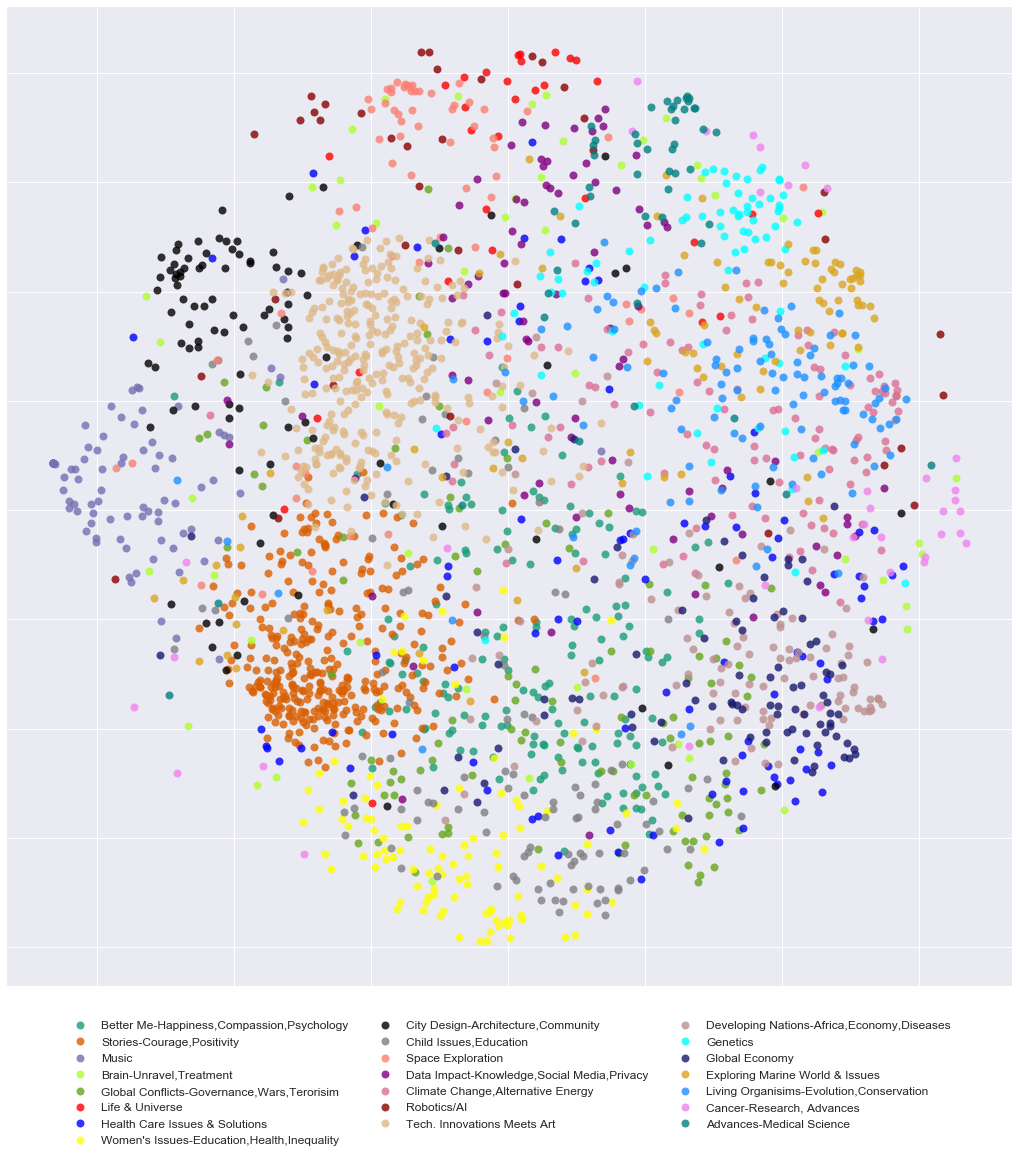

In [1406]:
# set up plot
fig, ax = plt.subplots(figsize=(18, 18)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=8, 
             label=topic_names22[name], alpha=0.8,color=topic_colors22[name],                        
            mec='none')
    
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1,loc ='center',bbox_to_anchor=(0.5, -.1), ncol=3, fontsize = 12)  #show legend with only 1 point

'''
#add label in x,y position with the label as the  Headline
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['Headline'], size=8)  
'''

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

Note: Although the coloring and naming of the Topics is based on Top topic assigned to the Talk, the position of the data pts. for each talk is from the nmf topic matrix that represents all the topic wts for that particular talk

So you can see the relationship on any particular Talk in comparision to Talks from other topics and build a relationship

In [620]:
NMF_Frame22['Topic'].value_counts() #number of talks per cluster (clusters from 0 to 21)

1     340
14    314
0     162
12    114
15    114
19    113
9     108
4     105
7     102
18    100
8      99
6      94
17     92
11     85
2      83
16     77
10     71
3      56
21     50
20     39
13     37
5      31
Name: Topic, dtype: int64

### Make a new DF Adding Topics Description Column

In [681]:
NMF_Frame22.columns

Index(['Id', 'Speaker', 'Headline', 'Tags', 'Views', 'Topic', 'PubMonth',
       'PubYear'],
      dtype='object')

In [695]:
Top_NMF_Frame22 = NMF_Frame22.filter(['Id', 'Speaker', 'Headline', 'Tags', 'Views', 'Topic', 'PubMonth',
       'PubYear'])

In [696]:
Top_NMF_Frame22.reset_index(drop=True, inplace=True)

In [697]:
Top_NMF_Frame22['TopicName']=0

In [698]:
for index, row in Top_NMF_Frame22.iterrows():
    TopicNum = Top_NMF_Frame22.iloc[index,5]
    Top_NMF_Frame22.iloc[index,8]=topic_short[TopicNum]   #Assigning topic from dictionary of short topics

## Topic Wise Viewership Analysis

#### HeatMap with Viewership Levels

#### Creating a DataFrame with Top and Bottom 25 Talks interms of viewership from NMF_Frame22

In [700]:
Top_NMF_Frame22.head()

,Id,Speaker,Headline,Tags,Views,Topic,PubMonth,PubYear,TopicName
0,1.0,Al Gore,Averting the climate crisis,"cars,alternative energy,culture,politics,scien...",3177001.0,12,6,2006,Climate Change
1,2.0,Amy Smith,Simple designs to save a life,"MacArthur grant,simplicity,industrial design,a...",1379328.0,19,8,2006,Living Organisims
2,3.0,Ashraf Ghani,How to rebuild a broken state,"corruption,poverty,economics,investment,milita...",790536.0,15,10,2006,Developing Nations Is.
3,4.0,Burt Rutan,The real future of space exploration,"aircraft,flight,industrial design,NASA,rocket ...",1985119.0,14,10,2006,Tech. Meet Art
4,5.0,Chris Bangle,Great cars are great art,"cars,industrial design,transportation,inventio...",859487.0,14,4,2007,Tech. Meet Art


Create seperate DFs for Top and Bottom 25 and add a Col Indicating Top or Bottom

In [701]:
TopView25 = Top_NMF_Frame22.sort_values(by=['Views'],ascending=False).head(25)

In [702]:
TopView25['Popularity']='Top25'

In [703]:
BotView25 = Top_NMF_Frame22.sort_values(by=['Views'],ascending=True).head(25)

In [704]:
BotView25['Popularity']='Bottom25'

Concatenating the Top & Botom Df

In [705]:
TopBot25 = pd.concat([TopView25,BotView25])

In [706]:
TopBot25.shape

(50, 10)

In [707]:
TopBot25.tail()

,Id,Speaker,Headline,Tags,Views,Topic,PubMonth,PubYear,TopicName,Popularity
322,394.0,Lee Smolin,Science and democracy,"String theory,physics,politics,social change,s...",253557.0,10,11,2008,Space Exploration,Bottom25
1152,1445.0,Bart Knols,3 new ways to kill mosquitoes,"insects,health,medicine,TEDx,global issues",255544.0,19,5,2012,Living Organisims,Bottom25
532,674.0,Dayananda Saraswati,The profound journey of compassion,"charter for compassion,self,compassion,religio...",264392.0,0,10,2008,Better Me,Bottom25
1035,1294.0,Srdja Popovic,How to topple a dictator,"protests,TEDx,culture,activism,politics,global...",267283.0,4,12,2011,Global Conflict,Bottom25
1158,1452.0,Michael McDaniel,"Cheap, effective shelter for disaster relief","natural disaster,TEDx,disaster relief,design,g...",267626.0,14,5,2012,Tech. Meet Art,Bottom25


In [708]:
TopBot25[TopBot25['Topic']==0]

,Id,Speaker,Headline,Tags,Views,Topic,PubMonth,PubYear,TopicName,Popularity
1260,1569.0,Amy Cuddy,Your body language shapes who you are,"TED Brain Trust,success,body language,psycholo...",41505006.0,0,10,2012,Better Me,Top25
89,96.0,Tony Robbins,Why we do what we do,"goal-setting,psychology,motivation,culture,pot...",19981744.0,0,6,2006,Better Me,Top25
1696,2034.0,Julian Treasure,How to speak so that people want to listen,"sound,culture,speech",19512254.0,0,6,2014,Better Me,Top25
485,618.0,Dan Pink,The puzzle of motivation,"brain,motivation,social change,science,work,cr...",18253944.0,0,8,2009,Better Me,Top25
1099,1377.0,Susan Cain,The power of introverts,"psychology,culture,business",16957684.0,0,3,2012,Better Me,Top25
995,1246.0,Pamela Meyer,How to spot a liar,"psychology,culture,science,society",16265867.0,0,10,2011,Better Me,Top25
90,97.0,Dan Gilbert,The surprising science of happiness,"TED Brain Trust,happiness,psychology,evolution...",14329603.0,0,9,2006,Better Me,Top25
531,673.0,Jackie Tabick,The balancing act of compassion,"charter for compassion,compassion,religion,glo...",171115.0,0,10,2008,Better Me,Bottom25
1119,1407.0,Rick Falkvinge,I am a pirate,"TEDx,politics,global issues,technology,Internet",174142.0,0,4,2012,Better Me,Bottom25
536,679.0,Robert Wright,The evolution of compassion,"charter for compassion,compassion,evolution,gl...",227817.0,0,10,2008,Better Me,Bottom25


In [716]:
PivotTopBot25 = TopBot25.pivot_table(index="Popularity",columns="TopicName",values="Views",
                                      aggfunc=lambda x: x.count())

In [717]:
PivotTopBot25

TopicName,Better Me,Brain Unravel,Child Issues,Climate Change,Data Impact,Developing Nations Is.,Global Conflict,Health Care,Living Organisims,Marine World,Space Exploration,Stories Positivity,Tech. Meet Art,Women's Issues
Popularity,,,,,,,,,,,,,,
Bottom25,4.0,NaN,NaN,1.0,1.0,2.0,1.0,1.0,3.0,3.0,1.0,4.0,4.0,NaN
Top25,7.0,2.0,1.0,NaN,NaN,2.0,NaN,2.0,NaN,1.0,NaN,7.0,2.0,1.0


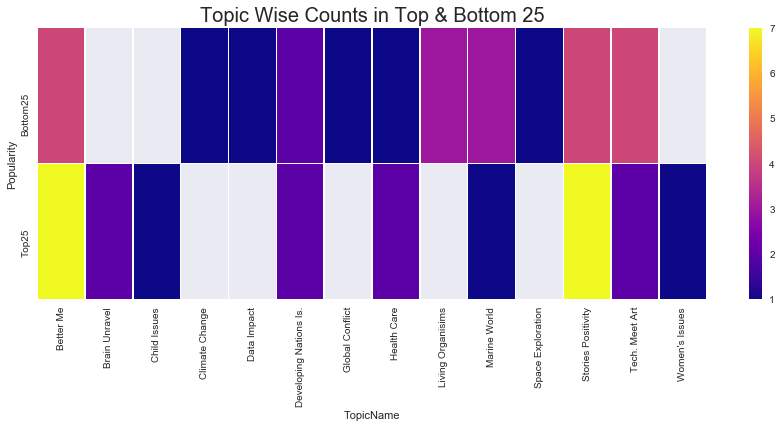

In [1262]:
fig, ax = plt.subplots(figsize=(15,5))
plt.title('Topic Wise Counts in Top & Bottom 25',size=20)
sns.heatmap(PivotTopBot25, cmap=cm.plasma, linewidths=.5, ax=ax);

## Analyzing Top50 and Bottom 50 Talks in terms of viewership

Create seperate DFs for Top and Bottom 50 and add a Col Indicating Top or Bottom

In [712]:
TopView50 = Top_NMF_Frame22.sort_values(by=['Views'],ascending=False).head(50)

In [713]:
TopView50['Popularity']='Top50'

In [714]:
BotView50 = Top_NMF_Frame22.sort_values(by=['Views'],ascending=True).head(50)

In [715]:
BotView50['Popularity']='Bottom50'

Concatenating the Top & Botom Df

In [719]:
TopBot50 = pd.concat([TopView50,BotView50])

In [720]:
TopBot50.shape

(100, 10)

In [721]:
TopBot50.tail()

,Id,Speaker,Headline,Tags,Views,Topic,PubMonth,PubYear,TopicName,Popularity
754,978.0,Peter Haas,Haiti's disaster of engineering,"natural disaster,architecture,disaster relief,...",312152.0,8,10,2010,City Design,Bottom50
822,1064.0,Kate Orff,Reviving New York's rivers -- with oysters!,"biology,architecture,cities,design",312482.0,19,1,2011,Living Organisims,Bottom50
362,441.0,Sherwin Nuland,The extraordinary power of ordinary people,"philanthropy,philosophy,writing",312909.0,0,1,2009,Better Me,Bottom50
1073,1345.0,Erica Frenkel,The universal anesthesia machine,"Surgery,poverty,health care,TEDx,design,global...",313559.0,6,2,2012,Health Care,Bottom50
224,255.0,Hector Ruiz,The thinking behind 50x15,"philanthropy,Africa,education,global issues,te...",313833.0,15,5,2008,Developing Nations Is.,Bottom50


Check for counts in Top and Bottom of Heatmap Plot

In [722]:
len(TopBot50[TopBot50['Topic']==0])

20

In [723]:
PivotTopBot50 = TopBot50.pivot_table(index="Popularity",columns="TopicName",values="Views",
                                      aggfunc=lambda x: x.count())

In [724]:
PivotTopBot50

TopicName,Better Me,Brain Unravel,Child Issues,City Design,Climate Change,Data Impact,Developing Nations Is.,Global Conflict,Global Economy,Health Care,Living Organisims,Marine World,Music,Space Exploration,Stories Positivity,Tech. Meet Art,Women's Issues
Popularity,,,,,,,,,,,,,,,,,
Bottom50,7.0,NaN,NaN,3.0,1.0,2.0,5.0,3.0,1.0,4.0,4.0,5.0,NaN,1.0,5.0,7.0,2.0
Top50,13.0,2.0,3.0,NaN,1.0,NaN,2.0,NaN,2.0,3.0,NaN,1.0,3.0,1.0,13.0,4.0,2.0


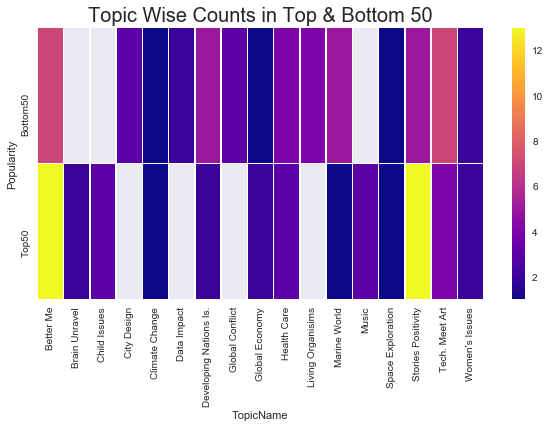

In [1263]:
fig, ax = plt.subplots(figsize=(10,5))
plt.title('Topic Wise Counts in Top & Bottom 50',size=20)
sns.heatmap(PivotTopBot50, cmap=cm.plasma, linewidths=.5, ax=ax);

### Analyzing Top100 Vs Bottom 100

Create seperate DFs for Top and Bottom 100 and add a Col Indicating Top or Bottom

In [726]:
TopView100 = Top_NMF_Frame22.sort_values(by=['Views'],ascending=False).head(100)

In [727]:
TopView100['Popularity']='Top100'

In [728]:
BotView100 = Top_NMF_Frame22.sort_values(by=['Views'],ascending=True).head(100)

In [729]:
BotView100['Popularity']='Bottom100'

Concatenating the Top & Botom Df

In [730]:
TopBot100 = pd.concat([TopView100,BotView100])

In [731]:
TopBot100.shape

(200, 10)

In [732]:
TopBot100.tail()

,Id,Speaker,Headline,Tags,Views,Topic,PubMonth,PubYear,TopicName,Popularity
2379,2795.0,Rhiannon Giddens,Songs that bring history to life,"history,live music,music",378435.0,2,6,2017,Music,Bottom100
383,474.0,Brenda Laurel,Why not make video games for girls?,"gaming,culture,history,women,children,design,e...",379005.0,14,3,2009,Tech. Meet Art,Bottom100
298,358.0,Noah Feldman,Politics and religion are technologies,"culture,religion,war,politics,social change,de...",380390.0,4,10,2008,Global Conflict,Bottom100
616,797.0,Eric Dishman,Take health care off the mainframe,"health,health care,science,technology,business",381457.0,6,3,2010,Health Care,Bottom100
50,55.0,Jehane Noujaim,My wish: A global day of film,"TED Prize,film,culture,social change,entertain...",381970.0,1,7,2006,Stories Positivity,Bottom100


Check for counts in Top and Bottom of Heatmap Plot

In [733]:
len(TopBot100[TopBot100['Topic']==0])

26

### Top & Bottom 100 --> Topic wise Counts

In [751]:
PivotTopBot100 = TopBot100.pivot_table(index="Popularity",columns="TopicName",values="Views",
                                      aggfunc=lambda x: x.count())

In [752]:
PivotTopBot100

TopicName,Advances Medicine Sc.,Better Me,Brain Unravel,Child Issues,City Design,Climate Change,Data Impact,Developing Nations Is.,Genetics,Global Conflict,...,Health Care,Life & Universe,Living Organisims,Marine World,Music,Robotics/AI,Space Exploration,Stories Positivity,Tech. Meet Art,Women's Issues
Popularity,,,,,,,,,,,,,,,,,,,,,
Bottom100,NaN,8.0,NaN,2.0,4.0,2.0,3.0,10.0,NaN,6.0,...,7.0,1.0,6.0,14.0,3.0,1.0,1.0,12.0,15.0,3.0
Top100,2.0,18.0,4.0,9.0,1.0,2.0,2.0,3.0,1.0,2.0,...,4.0,NaN,1.0,1.0,8.0,NaN,3.0,23.0,11.0,3.0


### Note: Makes more sense to look at the count and not the average viewership as the 2 classes her Top25 & Bottom25 takes care of the viewership already.
Here we are more keen to know the counts as that shows which topics are contributing to High or Low viewrship

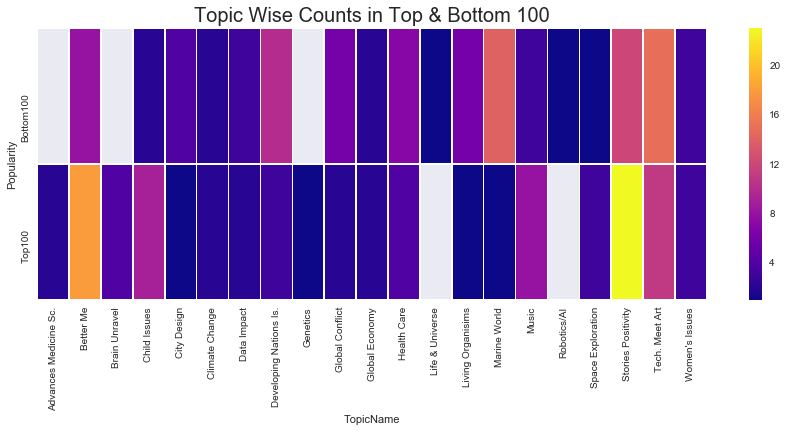

In [1266]:
fig, ax = plt.subplots(figsize=(15,5))
plt.title('Topic Wise Counts in Top & Bottom 100',size=20)
sns.heatmap(PivotTopBot100, cmap=cm.plasma, linewidths=.5, ax=ax);

### Top & Bottom 100 --> Topic wise Avg. Viewership

In [754]:
ViewPivotTopBot100 = TopBot100.pivot_table(index="Popularity",columns="TopicName",values="Views",
                                      aggfunc=lambda x: x.mean())

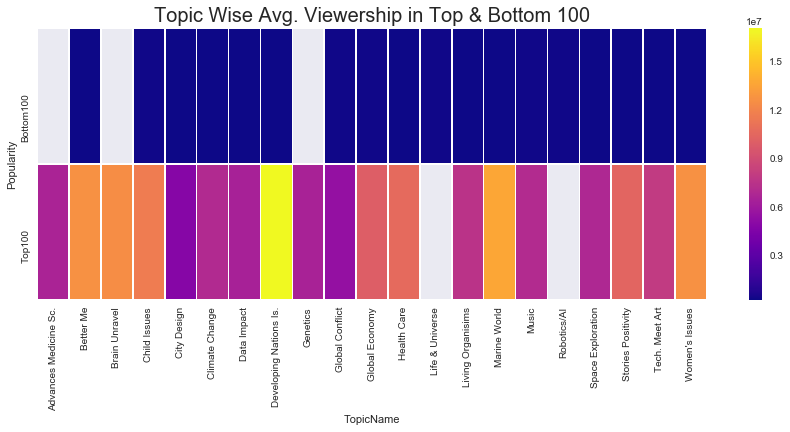

In [1268]:
fig, ax = plt.subplots(figsize=(15,5))
plt.title('Topic Wise Avg. Viewership in Top & Bottom 100',size=20)
sns.heatmap(ViewPivotTopBot100, cmap=cm.plasma, linewidths=.5, ax=ax);

### Overall Topic Wise Count

In [776]:
CountPivotOverall = Top_NMF_Frame22.pivot_table(columns="TopicName",values="Topic",
                                      aggfunc=lambda x: x.count())

In [777]:
CountPivotOverall

TopicName,Advances Medicine Sc.,Better Me,Brain Unravel,CancerResearch,Child Issues,City Design,Climate Change,Data Impact,Developing Nations Is.,Genetics,...,Health Care,Life & Universe,Living Organisims,Marine World,Music,Robotics/AI,Space Exploration,Stories Positivity,Tech. Meet Art,Women's Issues
Topic,50,162,56,39,108,99,114,85,114,77,...,94,31,113,100,83,37,71,340,314,102


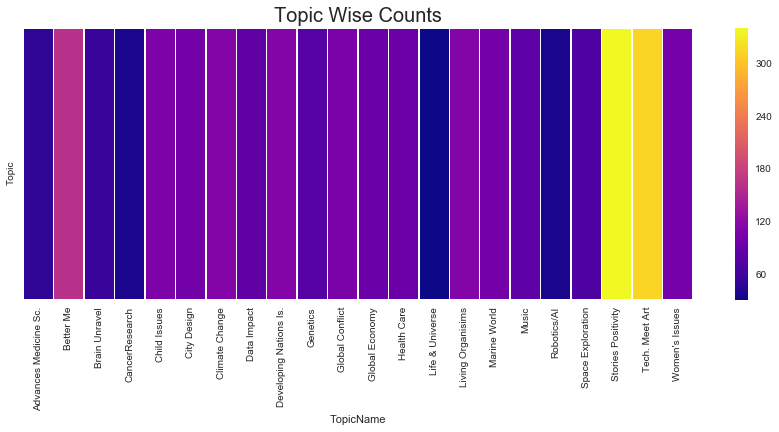

In [1269]:
fig, ax = plt.subplots(figsize=(15,5))
plt.title('Topic Wise Counts',size=20)
sns.heatmap(CountPivotOverall, cmap=cm.plasma, linewidths=.5, ax=ax);

### Overall Topic Wise Average Viewership

In [782]:
ViewPivotOverall = Top_NMF_Frame22.pivot_table(columns="TopicName",values="Views",
                                      aggfunc=lambda x: x.mean())

In [783]:
ViewPivotOverall

TopicName,Advances Medicine Sc.,Better Me,Brain Unravel,CancerResearch,Child Issues,City Design,Climate Change,Data Impact,Developing Nations Is.,Genetics,...,Health Care,Life & Universe,Living Organisims,Marine World,Music,Robotics/AI,Space Exploration,Stories Positivity,Tech. Meet Art,Women's Issues
Views,1546209.26,2.987625e+06,2.513969e+06,1.176604e+06,2.458563e+06,1.162043e+06,1.237095e+06,1.387145e+06,1.494542e+06,1.164973e+06,...,1.399976e+06,1.144272e+06,1.268315e+06,1177797.87,1.958930e+06,1.361770e+06,1.686881e+06,2.191294e+06,1.466282e+06,1.681169e+06


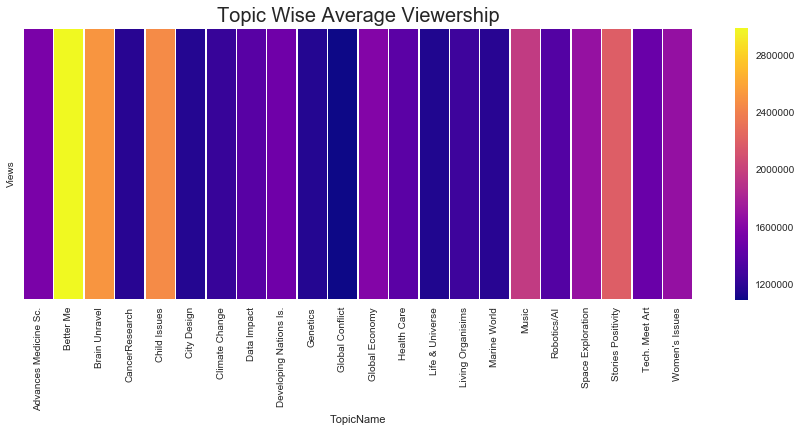

In [784]:
fig, ax = plt.subplots(figsize=(15,5))
plt.title('Topic Wise Average Viewership',size=20)
sns.heatmap(ViewPivotOverall, cmap=cm.plasma, linewidths=.5, ax=ax);

## Size of Topics-- > No. of talks in every Topic

In [1430]:
Top_NMF_Frame22.groupby('TopicName').Id.count().sort_values()

TopicName
Life & Universe            31
Robotics/AI                37
CancerResearch             39
Advances Medicine Sc.      50
Brain Unravel              56
Space Exploration          71
Genetics                   77
Music                      83
Data Impact                85
Global Economy             92
Health Care                94
City Design                99
Marine World              100
Women's Issues            102
Global Conflict           105
Child Issues              108
Living Organisims         113
Developing Nations Is.    114
Climate Change            114
Better Me                 162
Tech. Meet Art            314
Stories Positivity        340
Name: Id, dtype: int64

### Topic wise average viewrship in every year

### Groupig no. of talks published by the year

In [1386]:
Top_NMF_Frame22.groupby('PubYear').Id.count()

PubYear
2006     50
2007    119
2008    185
2009    215
2010    233
2011    246
2012    275
2013    241
2014    240
2015    220
2016    243
2017    119
Name: Id, dtype: int64

In [1390]:
ViewPivotYearly = Top_NMF_Frame22.pivot_table(index="PubYear",columns="TopicName",values="Views",
                                      aggfunc=lambda x: x.mean())

In [1391]:
ViewPivotYearly

TopicName,Advances Medicine Sc.,Better Me,Brain Unravel,CancerResearch,Child Issues,City Design,Climate Change,Data Impact,Developing Nations Is.,Genetics,...,Health Care,Life & Universe,Living Organisims,Marine World,Music,Robotics/AI,Space Exploration,Stories Positivity,Tech. Meet Art,Women's Issues
PubYear,,,,,,,,,,,,,,,,,,,,,
2006,3.203048e+06,1.160144e+07,NaN,1.637050e+06,2.803564e+07,1.270351e+06,3.177001e+06,6.872959e+06,7.424682e+05,1.639084e+06,...,3.735740e+05,NaN,1.379328e+06,7.281160e+05,3.184913e+06,NaN,1.955842e+06,1.870407e+06,2.198593e+06,5.083531e+06
2007,1.189252e+06,2.176755e+06,2.588675e+06,NaN,2.913086e+06,8.636709e+05,9.828965e+05,3.064790e+05,8.241123e+05,9.999058e+05,...,8.436710e+05,2175338.000,1.723105e+06,1.820280e+06,2.554975e+06,9.491280e+05,1.497862e+06,1.468687e+06,1.483981e+06,5.701300e+05
2008,NaN,1.386556e+06,6.831996e+06,1.023525e+06,9.727074e+05,6.304203e+05,7.583183e+05,7.312320e+05,4.442454e+05,1.143510e+06,...,6.569535e+05,559326.800,1.451572e+06,2.420331e+06,1.707208e+06,6.858520e+05,2.618671e+06,1.450986e+06,9.369797e+05,2.366378e+06
2009,1.694329e+06,3.573902e+06,1.890432e+06,NaN,1.664484e+06,8.985401e+05,7.092718e+05,7.908076e+05,2.085744e+06,8.064056e+05,...,4.591905e+05,830696.000,1.143912e+06,7.710864e+05,1.371232e+06,9.193352e+05,1.310933e+06,1.868342e+06,1.590634e+06,5.279933e+06
2010,1.150937e+06,2.071082e+06,1.501598e+06,1.779921e+06,1.767583e+06,5.530513e+05,9.912025e+05,9.648602e+05,3.051545e+06,8.056135e+05,...,6.403150e+05,866538.000,1.241852e+06,6.832611e+05,1.249930e+06,1.286170e+06,1.265976e+06,3.876524e+06,1.456684e+06,2.034826e+06
2011,1.585747e+06,2.086822e+06,2.009111e+06,8.626115e+05,2.203679e+06,1.512750e+06,2.376724e+06,1.656980e+06,6.124735e+05,1.026101e+06,...,8.485238e+05,1069762.000,1.138690e+06,9.168183e+05,1.474647e+06,9.302288e+05,1.618371e+06,2.297620e+06,1.031599e+06,1.452380e+06
2012,1.529846e+06,4.680859e+06,3.525978e+06,9.018552e+05,1.381574e+06,1.243139e+06,1.126299e+06,1.169090e+06,1.445414e+06,8.527814e+05,...,9.397895e+05,712212.500,7.448483e+05,7.121167e+05,2.684230e+06,2.510869e+06,2.161997e+06,2.423734e+06,1.310383e+06,7.799100e+05
2013,1.268225e+06,2.887206e+06,2.068744e+06,3.576218e+06,2.719358e+06,1.156117e+06,1.514334e+06,1.877570e+06,1.369928e+06,1.156829e+06,...,2.327090e+06,NaN,1.884494e+06,1.659178e+06,4.011947e+06,1.279043e+06,1.722938e+06,2.974643e+06,2.326772e+06,1.581528e+06
2014,1.964837e+06,3.147372e+06,1.642065e+06,1.012594e+06,2.811539e+06,1.162551e+06,1.417576e+06,1.394054e+06,1.989692e+06,1.878262e+06,...,1.271067e+06,1470790.500,1.476188e+06,1.371136e+06,1.268090e+06,1.937070e+06,1.980482e+06,2.246903e+06,1.474922e+06,1.584794e+06


Here Average is caluclated like this:
For each yr. ---> 
Sum of Views of all talks on a specific topic are added and then divide by no. of talks on that specific topic
in that year...so the comparison can be both within the year to other topics viewership and also within the topic column with other years
As the unit for each cell in the graph and pivot is -->Avg views of Talks on Topic A held in year B

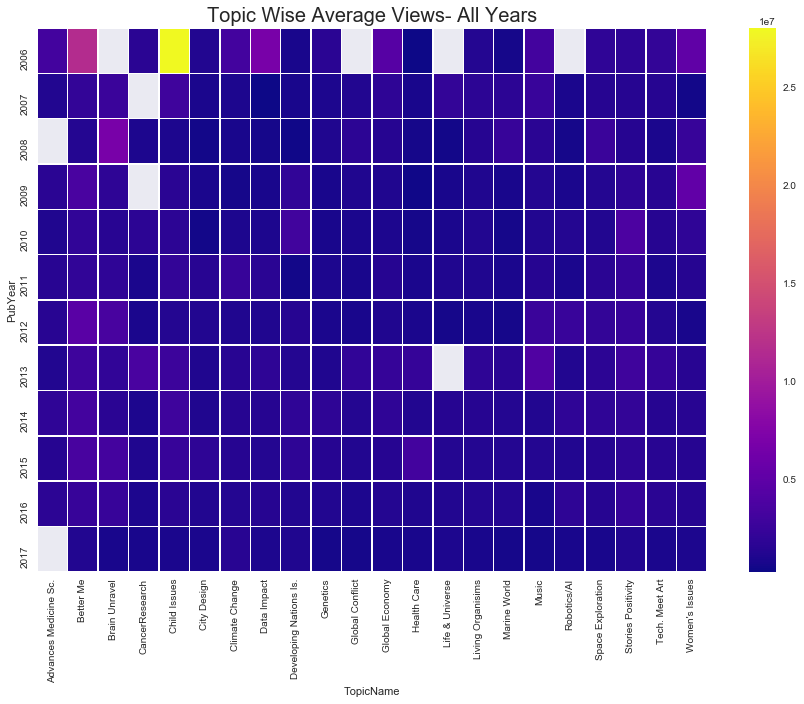

In [1399]:
fig, ax = plt.subplots(figsize=(15,10))
plt.title('Topic Wise Average Views- All Years',size=20)
sns.heatmap(ViewPivotYearly, cmap=cm.plasma, linewidths=.5, ax=ax);

### Topic Wise Yearly Average Log(Views)   
----> So that some more Popular Topics over the years can emerge beside the Ken Robinson Speech 

In [1393]:
LogViewPivotYearly = Top_NMF_Frame22.pivot_table(index="PubYear",columns="TopicName",values="Views",
                                      aggfunc=lambda x: log(x).mean())

In [1394]:
LogViewPivotYearly

TopicName,Advances Medicine Sc.,Better Me,Brain Unravel,CancerResearch,Child Issues,City Design,Climate Change,Data Impact,Developing Nations Is.,Genetics,...,Health Care,Life & Universe,Living Organisims,Marine World,Music,Robotics/AI,Space Exploration,Stories Positivity,Tech. Meet Art,Women's Issues
PubYear,,,,,,,,,,,,,,,,,,,,,
2006,14.979613,16.023998,NaN,14.231331,16.898939,14.019180,14.971448,15.743105,13.477097,14.250237,...,12.830871,NaN,14.137107,13.498216,14.857020,NaN,14.371914,14.141852,14.254602,14.968031
2007,13.834819,14.267312,14.681359,NaN,14.761186,13.572125,13.746937,12.632905,13.542143,13.686921,...,13.645518,14.574290,14.357329,14.090684,14.672155,13.726803,14.179775,13.750868,13.973810,13.253620
2008,NaN,13.566262,14.906385,13.797783,13.661564,13.298490,13.329421,13.502486,12.905340,13.762609,...,13.323705,13.193105,13.768557,13.842050,13.610769,13.429659,14.405015,13.718331,13.484276,14.494782
2009,13.963112,14.581057,14.318639,NaN,14.214504,13.511704,13.381363,13.421781,13.765869,13.416732,...,12.967226,13.630019,13.761949,13.462183,13.976798,13.677650,13.864772,13.892395,13.700627,14.327472
2010,13.808328,14.401468,14.150962,13.974695,14.087349,13.163640,13.579153,13.600076,13.751192,13.538665,...,13.248882,13.628528,13.665719,13.235165,13.896313,13.940237,13.964333,14.360365,13.932214,14.061633
2011,13.843772,14.092678,14.327989,13.522686,14.363962,14.056176,14.320885,14.069867,13.259709,13.758474,...,13.503209,13.882947,13.845835,13.565634,13.903403,13.685847,13.904521,14.247559,13.770978,13.926786
2012,14.094457,14.467068,14.253109,13.588784,14.075418,13.783367,13.803927,13.820030,13.970397,13.595712,...,13.592905,13.476120,13.321411,13.265196,14.589360,14.372485,14.299525,14.407410,13.881251,13.445259
2013,13.988923,14.573293,14.349381,15.055172,14.470312,13.901030,14.076377,14.220244,14.023249,13.898683,...,13.932646,NaN,14.313581,14.088477,14.914048,14.035407,14.353902,14.601085,14.257907,14.059830
2014,14.147429,14.568720,14.129550,13.820310,14.685289,13.906088,14.061504,14.098530,14.259444,14.177700,...,14.019302,14.190915,14.077291,14.085222,13.938652,14.427091,14.377639,14.471466,14.146691,14.187068


Here Average is caluclated like this:
For each yr. ---> 
Sum of Views of all talks on a specific topic are added and then divide by no. of talks on that specific topic
in that year...so the comparison can be both within the year to other topics viewership and also within the topic column with other years
As the unit for each cell in the graph and pivot is -->Avg views of Talks on Topic A held in year B

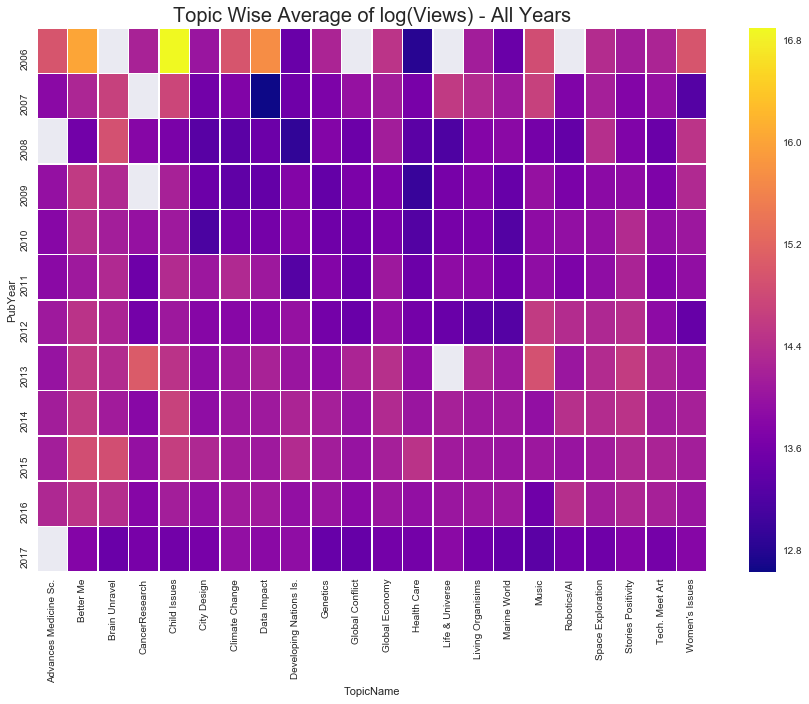

In [1400]:
fig, ax = plt.subplots(figsize=(15,10))
plt.title('Topic Wise Average of log(Views) - All Years',size=20)
sns.heatmap(LogViewPivotYearly, cmap=cm.plasma, linewidths=.5, ax=ax);

In [1411]:
topic_names22

{0: 'Better Me-Happiness,Compassion,Psychology',
 1: 'Stories-Courage,Positivity',
 2: 'Music',
 3: 'Brain-Unravel,Treatment',
 4: 'Global Conflicts-Governance,Wars,Terorisim',
 5: 'Life & Universe',
 6: 'Health Care Issues & Solutions',
 7: "Women's Issues-Education,Health,Inequality",
 8: 'City Design-Architecture,Community',
 9: 'Child Issues,Education',
 10: 'Space Exploration',
 11: 'Data Impact-Knowledge,Social Media,Privacy',
 12: 'Climate Change,Alternative Energy',
 13: 'Robotics/AI',
 14: 'Tech. Innovations Meets Art',
 15: 'Developing Nations-Africa,Economy,Diseases',
 16: 'Genetics',
 17: 'Global Economy',
 18: 'Exploring Marine World & Issues',
 19: 'Living Organisims-Evolution,Conservation',
 20: 'Cancer-Research, Advances',
 21: 'Advances-Medical Science'}

In [1271]:
topic_short

{0: 'Better Me',
 1: 'Stories Positivity',
 2: 'Music',
 3: 'Brain Unravel',
 4: 'Global Conflict',
 5: 'Life & Universe',
 6: 'Health Care',
 7: "Women's Issues",
 8: 'City Design',
 9: 'Child Issues',
 10: 'Space Exploration',
 11: 'Data Impact',
 12: 'Climate Change',
 13: 'Robotics/AI',
 14: 'Tech. Meet Art',
 15: 'Developing Nations Is.',
 16: 'Genetics',
 17: 'Global Economy',
 18: 'Marine World',
 19: 'Living Organisims',
 20: 'CancerResearch',
 21: 'Advances Medicine Sc.'}

In [1273]:
TopBot25

,Id,Speaker,Headline,Tags,Views,Topic,PubMonth,PubYear,TopicName,Popularity
61,66.0,Ken Robinson,Do schools kill creativity?,"dance,education,culture,parenting,children,tea...",45622906.0,9,6,2006,Child Issues,Top25
1260,1569.0,Amy Cuddy,Your body language shapes who you are,"TED Brain Trust,success,body language,psycholo...",41505006.0,0,10,2012,Better Me,Top25
650,848.0,Simon Sinek,How great leaders inspire action,"success,TEDx,leadership,entrepreneur,business",32664300.0,15,5,2010,Developing Nations Is.,Top25
801,1042.0,BrenÌ© Brown,The power of vulnerability,"depression,mental health,psychology,self,TEDx,...",29931236.0,1,12,2010,Stories Positivity,Top25
438,549.0,Mary Roach,10 things you didn't know about orgasm,"sex,books,culture,history,science,humor,writing",21902550.0,7,5,2009,Women's Issues,Top25
201,229.0,Jill Bolte Taylor,My stroke of insight,"consciousness,illness,biology,brain,science,gl...",20643201.0,3,3,2008,Brain Unravel,Top25
89,96.0,Tony Robbins,Why we do what we do,"goal-setting,psychology,motivation,culture,pot...",19981744.0,0,6,2006,Better Me,Top25
1696,2034.0,Julian Treasure,How to speak so that people want to listen,"sound,culture,speech",19512254.0,0,6,2014,Better Me,Top25
1333,1647.0,Cameron Russell,"Looks aren't everything. Believe me, I'm a model.","fashion,photography,TEDx,culture,beauty",18809201.0,1,1,2013,Stories Positivity,Top25
485,618.0,Dan Pink,The puzzle of motivation,"brain,motivation,social change,science,work,cr...",18253944.0,0,8,2009,Better Me,Top25


### Topic wise count in every year

In [765]:
CountPivotYearly = Top_NMF_Frame22.pivot_table(index="PubYear",columns="TopicName",values="Topic",
                                      aggfunc=lambda x: x.count())

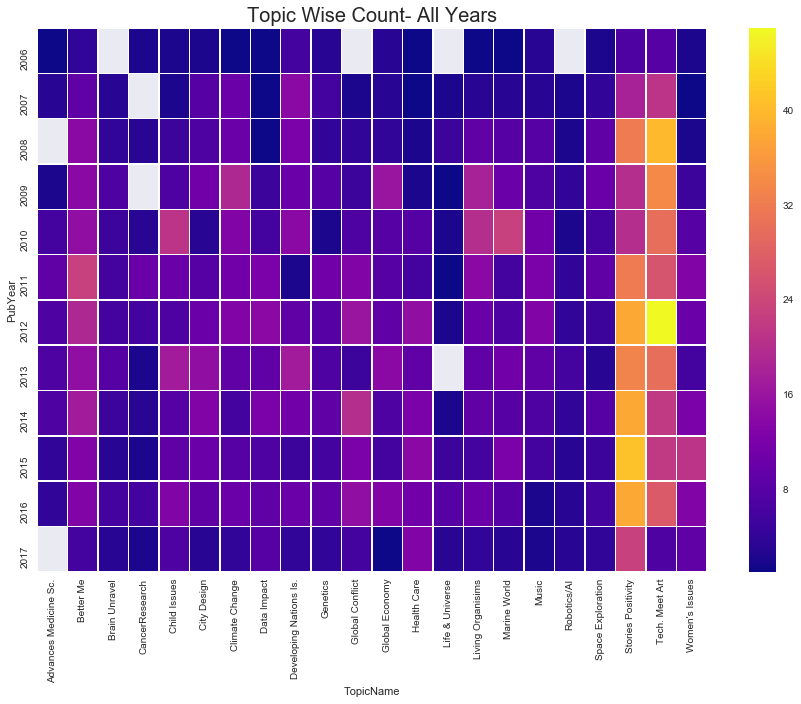

In [1407]:
fig, ax = plt.subplots(figsize=(15,10))
plt.title('Topic Wise Count- All Years',size=20)
sns.heatmap(CountPivotYearly, cmap=cm.plasma, linewidths=.5, ax=ax);

In [1276]:
Top_NMF_Frame22.Views.mean()

1695916.7271584242

19542374.12
2444474.531919845


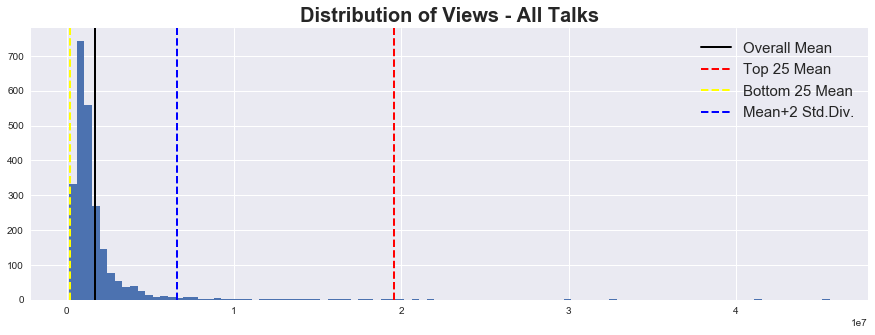

In [1410]:
Top_NMF_Frame22.hist(column='Views', figsize=(15,5), bins=100)


mean = Top_NMF_Frame22['Views'].mean()
top25mean= SentiTop25['views_as_of_06162017'].mean()
Bot25mean= SentiBot25['views_as_of_06162017'].mean()
stdiv = SentimentDF['views_as_of_06162017'].std()
print(top25mean)
print(stdiv)

plt.axvline(mean, color='black', linestyle='solid', linewidth=2,label="Overall Mean")
plt.axvline(top25mean, color='red', linestyle='dashed', linewidth=2,label="Top 25 Mean")
plt.axvline(Bot25mean, color='yellow', linestyle='dashed', linewidth=2,label="Bottom 25 Mean")
plt.axvline(mean+2*stdiv, color='blue', linestyle='dashed', linewidth=2,label="Mean+2 Std.Div.")


#plt.xlim(.25, .7)


plt.title('Distribution of Views - All Talks',fontsize=20,fontweight='bold')

leg = plt.legend(loc='upper right',fontsize = 15,fancybox=True)


plt.show()

## Sentiment Analysis

In [786]:
from textblob import TextBlob

In [789]:
TextBlob(Text).sentiment

Sentiment(polarity=0.1613569484267536, subjectivity=0.4294759281122918)

In [790]:
Data2.columns

Index(['id', 'speaker', 'headline', 'URL', 'description', 'transcript_URL',
       'month_filmed', 'year_filmed', 'event', 'duration', 'date_published',
       'views_as_of_06162017', 'tags', 'transcript', 'Pub_Year', 'Pub_Month'],
      dtype='object')

In [792]:
Data2[Data2['speaker']=='Amy Cuddy']

,id,speaker,headline,URL,description,transcript_URL,month_filmed,year_filmed,event,duration,date_published,views_as_of_06162017,tags,transcript,Pub_Year,Pub_Month
1260,1569.0,Amy Cuddy,Your body language shapes who you are,http://www.ted.com/talks/view/id/1569,"Body language affects how others see us, but i...",http://www.ted.com/talks/view/id/1569/transcri...,6.0,2012.0,TEDGlobal 2012,0:21:02,2012-10-01,41505006.0,"TED Brain Trust,success,body language,psycholo...",So I want to start by offering you a free no-t...,2012,10


In [794]:
Text2= Transcripts[1260]

In [801]:
TextBlob(Text2).sentiment

Sentiment(polarity=0.090749603701246, subjectivity=0.4828075462655757)

In [800]:
TextBlob(Text2).sentiment[1]

0.4828075462655757

## Creating a Sentiment Added DF

In [802]:
SentimentDF = Data2.filter(['id', 'speaker', 'headline', 'URL', 'description',
       'month_filmed', 'year_filmed', 'event', 'duration', 'date_published',
       'views_as_of_06162017', 'tags', 'transcript', 'Pub_Year', 'Pub_Month'])

In [827]:
TextBlob(SentimentDF.iloc[1,12]).sentiment

Sentiment(polarity=0.11817332376925406, subjectivity=0.49097270462096043)

#### Adding Columns for Polarity & Subjectivity

In [807]:
SentimentDF['Polarity']=0
SentimentDF['Subjectivity']=0

In [828]:
for index, row in SentimentDF.iterrows():
    SentimentDF.iloc[index,15] = TextBlob(SentimentDF.iloc[index,12]).sentiment[0] #Assign Polarity
    SentimentDF.iloc[index,16] = TextBlob(SentimentDF.iloc[index,12]).sentiment[1] #Assign Subjectivity


In [834]:
SentimentDF.head(2)

,id,speaker,headline,URL,description,month_filmed,year_filmed,event,duration,date_published,views_as_of_06162017,tags,transcript,Pub_Year,Pub_Month,Polarity,Subjectivity
0,1.0,Al Gore,Averting the climate crisis,http://www.ted.com/talks/view/id/1,With the same humor and humanity he exuded in ...,2.0,2006.0,TED2006,0:16:17,2006-06-27,3177001.0,"cars,alternative energy,culture,politics,scien...","Thank you so much, Chris. And it's truly a gre...",2006,6,0.161357,0.429476
1,2.0,Amy Smith,Simple designs to save a life,http://www.ted.com/talks/view/id/2,Fumes from indoor cooking fires kill more than...,2.0,2006.0,TED2006,0:15:06,2006-08-15,1379328.0,"MacArthur grant,simplicity,industrial design,a...","In terms of invention, I'd like to tell you th...",2006,8,0.118173,0.490973


 Adding a Columns for Top Topic No. & Top Topic Name to FullDF


In [1166]:
SentimentDF['Top_Topic']= DocTopicList22

Adding another column with Top Topic Name  to FullDF

In [1167]:
DocTopic_Names22 = Top_NMF_Frame22['TopicName']

In [1168]:
SentimentDF['Top_TopicName']=DocTopic_Names22

Create seperate DFs for Top and Bottom 25 and add a Col Indicating Top or Bottom

In [1170]:
SentiTop25 = SentimentDF.sort_values(by=['views_as_of_06162017'],ascending=False).head(25)

In [1171]:
SentiTop25['Popularity']='Top25'

In [1172]:
SentiBot25 = SentimentDF.sort_values(by=['views_as_of_06162017'],ascending=True).head(25)

In [1173]:
SentiBot25['Popularity']='Bottom25'

Concatenating the Top & Botom Df

In [1174]:
SentiTopBot25 = pd.concat([SentiTop25,SentiBot25])

In [1175]:
SentiTopBot25.shape

(50, 20)

### Top & Bottom 25 Talks 
--> Average Sentiment Comparison

In [1176]:
SentiPivotTopBot25 = SentiTopBot25.pivot_table(index="Popularity",values=["Polarity",'Subjectivity'],
                                      aggfunc=lambda x: x.mean())

In [1177]:
SentiPivotTopBot25

,Polarity,Subjectivity
Popularity,,
Bottom25,0.129066,0.474017
Top25,0.142676,0.485588


### Note: Should be plotted on different graphs as the 2 measures are  not comparable and are also two have different units of measurement 
As polarity goes from -1 to 1 and subjectivity 0 to 1 

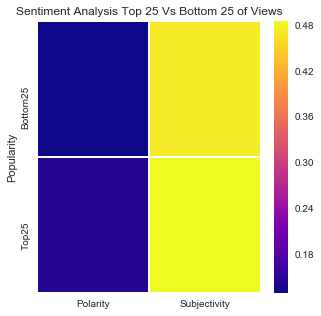

In [1178]:
fig, ax = plt.subplots(figsize=(5,5))
plt.title('Sentiment Analysis Top 25 Vs Bottom 25 of Views',size=12)
sns.heatmap(SentiPivotTopBot25, cmap=cm.plasma, linewidths=.5, ax=ax);

#### Comparing Top 25 & Bottom 25 in terms of sentiment

Create seperate DFs for Top and Bottom 25 and add a Col Indicating Top or Bottom

In [1179]:
SentiTop25 = SentimentDF.sort_values(by=['views_as_of_06162017'],ascending=False).head(25)

In [1180]:
SentiTop25['Popularity']='Top25'

In [1181]:
SentiBot25 = SentimentDF.sort_values(by=['views_as_of_06162017'],ascending=True).head(25)

In [1182]:
SentiBot25['Popularity']='Bottom25'

Concatenating the Top & Botom Df

In [1183]:
SentiTopBot25 = pd.concat([SentiTop25,SentiBot25])

In [1184]:
SentiTopBot25.shape

(50, 20)

### Comparision of Average Polarity by Topic -TopBot

**Note** Essential to Calculate average Polarity here as Sum of Polarity will be misleading as the count of the same Topic differs in Top & Bottom 

The pivot table calculates avg by dividing the sum of polarity of talks by count of Talks with that topic Top25/Bot25
(it doesn't divide all by 25)

In [1320]:
SentiTop25.columns

Index(['id', 'speaker', 'headline', 'URL', 'description', 'month_filmed',
       'year_filmed', 'event', 'duration', 'date_published',
       'views_as_of_06162017', 'tags', 'transcript', 'Pub_Year', 'Pub_Month',
       'Polarity', 'Subjectivity', 'Top_Topic', 'Top_TopicName', 'Popularity'],
      dtype='object')

In [1328]:
PolPivotTopBot25 = SentiTopBot25.pivot_table(index="Popularity",columns= 'Top_TopicName',values="Polarity",
                                      aggfunc=lambda x: x.mean())

In [1329]:
PolPivotTopBot25

Top_TopicName,Better Me,Brain Unravel,Child Issues,Climate Change,Data Impact,Developing Nations Is.,Global Conflict,Health Care,Living Organisims,Marine World,Space Exploration,Stories Positivity,Tech. Meet Art,Women's Issues
Popularity,,,,,,,,,,,,,,
Bottom25,0.152094,NaN,NaN,0.116792,0.176802,0.163718,0.067714,0.122166,0.150815,0.084020,0.12418,0.104762,0.139909,NaN
Top25,0.151957,0.154841,0.142933,NaN,NaN,0.126963,NaN,0.173056,NaN,0.202444,NaN,0.112724,0.149425,0.160175


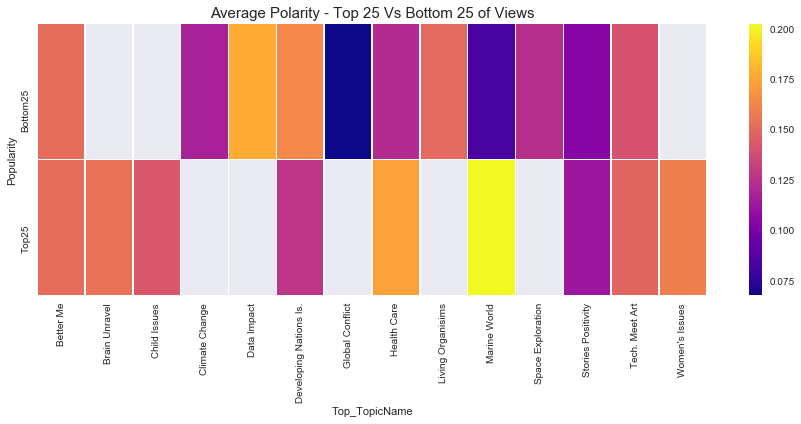

In [1412]:
fig, ax = plt.subplots(figsize=(15,5))
plt.title('Average Polarity - Top 25 Vs Bottom 25 of Views',size=15)
sns.heatmap(PolPivotTopBot25, cmap=cm.plasma, linewidths=.5, ax=ax);

In [1413]:
SubPivotTopBot25 = SentiTopBot25.pivot_table(index="Popularity",columns= 'Top_TopicName',values="Subjectivity",
                                      aggfunc=lambda x: x.mean())

In [1414]:
SubPivotTopBot25

Top_TopicName,Better Me,Brain Unravel,Child Issues,Climate Change,Data Impact,Developing Nations Is.,Global Conflict,Health Care,Living Organisims,Marine World,Space Exploration,Stories Positivity,Tech. Meet Art,Women's Issues
Popularity,,,,,,,,,,,,,,
Bottom25,0.478311,NaN,NaN,0.464186,0.481565,0.425919,0.458613,0.423699,0.468132,0.464614,0.441622,0.514280,0.490077,NaN
Top25,0.505532,0.42924,0.463061,NaN,NaN,0.454574,NaN,0.472443,NaN,0.496751,NaN,0.510907,0.415318,0.521657


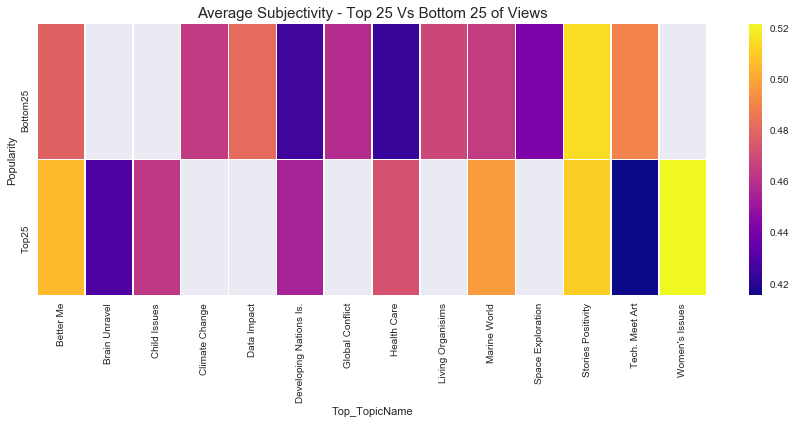

In [1416]:
fig, ax = plt.subplots(figsize=(15,5))
plt.title('Average Subjectivity - Top 25 Vs Bottom 25 of Views',size=15)
sns.heatmap(SubPivotTopBot25, cmap=cm.plasma, linewidths=.5, ax=ax);

In [1431]:
SentiTopBot25

,id,speaker,headline,URL,description,month_filmed,year_filmed,event,duration,date_published,views_as_of_06162017,tags,transcript,Pub_Year,Pub_Month,Polarity,Subjectivity,Top_Topic,Top_TopicName,Popularity
61,66.0,Ken Robinson,Do schools kill creativity?,http://www.ted.com/talks/view/id/66,Sir Ken Robinson makes an entertaining and pro...,2.0,2006.0,TED2006,0:19:24,2006-06-27,45622906.0,"dance,education,culture,parenting,children,tea...","Good morning. How are you? It's been great, ha...",2006,6,0.142933,0.463061,9,Child Issues,Top25
1260,1569.0,Amy Cuddy,Your body language shapes who you are,http://www.ted.com/talks/view/id/1569,"Body language affects how others see us, but i...",6.0,2012.0,TEDGlobal 2012,0:21:02,2012-10-01,41505006.0,"TED Brain Trust,success,body language,psycholo...",So I want to start by offering you a free no-t...,2012,10,0.090750,0.482808,0,Better Me,Top25
650,848.0,Simon Sinek,How great leaders inspire action,http://www.ted.com/talks/view/id/848,Simon Sinek has a simple but powerful model fo...,9.0,2009.0,TEDxPuget Sound,0:18:04,2010-05-04,32664300.0,"success,TEDx,leadership,entrepreneur,business",How do you explain when things don't go as we ...,2010,5,0.189045,0.487851,15,Developing Nations Is.,Top25
801,1042.0,BrenÌ© Brown,The power of vulnerability,http://www.ted.com/talks/view/id/1042,BrenÌ© Brown studies human connection -- our a...,6.0,2010.0,TEDxHouston,0:20:19,2010-12-23,29931236.0,"depression,mental health,psychology,self,TEDx,...","So, I'll start with this: a couple years ago, ...",2010,12,0.086774,0.535024,1,Stories Positivity,Top25
438,549.0,Mary Roach,10 things you didn't know about orgasm,http://www.ted.com/talks/view/id/549,"""Bonk"" author Mary Roach delves into obscure s...",2.0,2009.0,TED2009,0:16:43,2009-05-20,21902550.0,"sex,books,culture,history,science,humor,writing",Alright. I'm going to show you a couple of ima...,2009,5,0.160175,0.521657,7,Women's Issues,Top25
201,229.0,Jill Bolte Taylor,My stroke of insight,http://www.ted.com/talks/view/id/229,Jill Bolte Taylor got a research opportunity f...,2.0,2008.0,TED2008,0:18:19,2008-03-12,20643201.0,"consciousness,illness,biology,brain,science,gl...",I grew up to study the brain because I have a ...,2008,3,0.135087,0.417969,3,Brain Unravel,Top25
89,96.0,Tony Robbins,Why we do what we do,http://www.ted.com/talks/view/id/96,"Tony Robbins discusses the ""invisible forces"" ...",2.0,2006.0,TED2006,0:21:45,2006-06-27,19981744.0,"goal-setting,psychology,motivation,culture,pot...",Thank you. I have to tell you I'm both challen...,2006,6,0.123622,0.517481,0,Better Me,Top25
1696,2034.0,Julian Treasure,How to speak so that people want to listen,http://www.ted.com/talks/view/id/2034,"Have you ever felt like you're talking, but no...",6.0,2013.0,TEDGlobal 2013,0:09:58,2014-06-27,19512254.0,"sound,culture,speech",The human voice: It's the instrument we all pl...,2014,6,0.151946,0.565015,0,Better Me,Top25
1333,1647.0,Cameron Russell,"Looks aren't everything. Believe me, I'm a model.",http://www.ted.com/talks/view/id/1647,"Cameron Russell admits she won ""a genetic lott...",10.0,2012.0,TEDxMidAtlantic,0:09:37,2013-01-16,18809201.0,"fashion,photography,TEDx,culture,beauty","Hi. My name is Cameron Russell, and for the la...",2013,1,0.110200,0.554340,1,Stories Positivity,Top25
485,618.0,Dan Pink,The puzzle of motivation,http://www.ted.com/talks/view/id/618,Career analyst Dan Pink examines the puzzle of...,7.0,2009.0,TEDGlobal 2009,0:18:36,2009-08-24,18253944.0,"brain,motivation,social change,science,work,cr...",I need to make a confession at the outset here...,2009,8,0.177860,0.472101,0,Better Me,Top25


In [1432]:
SentiTopBot25.loc[650,'transcript']

'How do you explain when things don\'t go as we assume? Or better, how do you explain when others are able to achieve things that seem to defy all of the assumptions? For example: Why is Apple so innovative? Year after year, after year, they\'re more innovative than all their competition. And yet, they\'re just a computer company. They\'re just like everyone else. They have the same access to the same talent, the same agencies, the same consultants, the same media. Then why is it that they seem to have something different? Why is it that Martin Luther King led the Civil Rights Movement? He wasn\'t the only man who suffered in pre-civil rights America, and he certainly wasn\'t the only great orator of the day. Why him? And why is it that the Wright brothers were able to figure out controlled, powered man flight when there were certainly other teams who were better qualified, better funded and they didn\'t achieve powered man flight, and the Wright brothers beat them to it. There\'s some

## Plotting a histogram of Sentiment Analysis

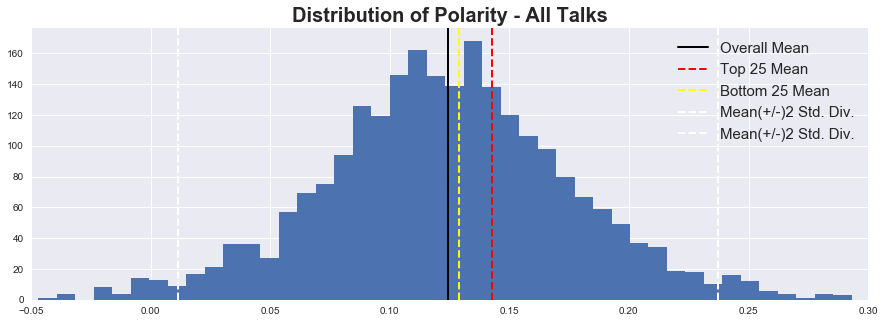

In [1294]:
SentimentDF.hist(column='Polarity', figsize=(15,5), bins=100)


mean = SentimentDF['Polarity'].mean()
top25mean= SentiTop25['Polarity'].mean()
Bot25mean= SentiBot25['Polarity'].mean()
stdiv= SentimentDF['Polarity'].std()

plt.axvline(mean, color='black', linestyle='solid', linewidth=2,label="Overall Mean")
plt.axvline(top25mean, color='red', linestyle='dashed', linewidth=2,label="Top 25 Mean")
plt.axvline(Bot25mean, color='yellow', linestyle='dashed', linewidth=2,label="Bottom 25 Mean")
plt.axvline(mean+2*stdiv, color='white', linestyle='dashed', linewidth=2,label="Mean(+/-)2 Std. Div.")
plt.axvline(mean-2*stdiv, color='white', linestyle='dashed', linewidth=2,label="Mean(+/-)2 Std. Div.")

plt.xlim(-.05, .3)

plt.title('Distribution of Polarity - All Talks',fontsize=20,fontweight='bold')

leg = plt.legend(loc='upper right',fontsize = 15,fancybox=True)




plt.show()

### Polarity Distribution plot for Better Me

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15e7e4710>]], dtype=object)

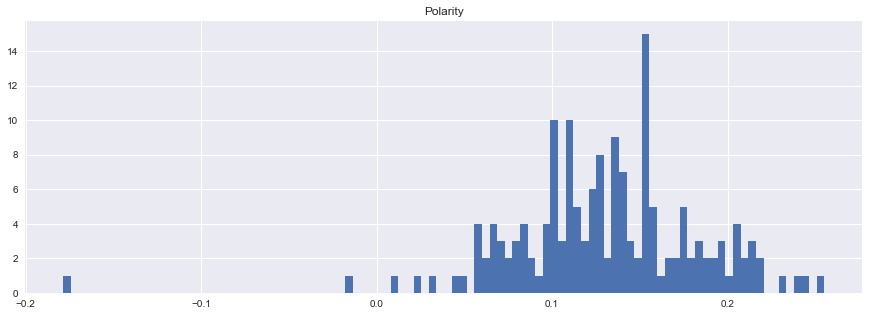

In [1418]:
SentimentDF[SentimentDF['Top_TopicName']=='Better Me'].hist(column='Polarity', figsize=(15,5), bins=100)

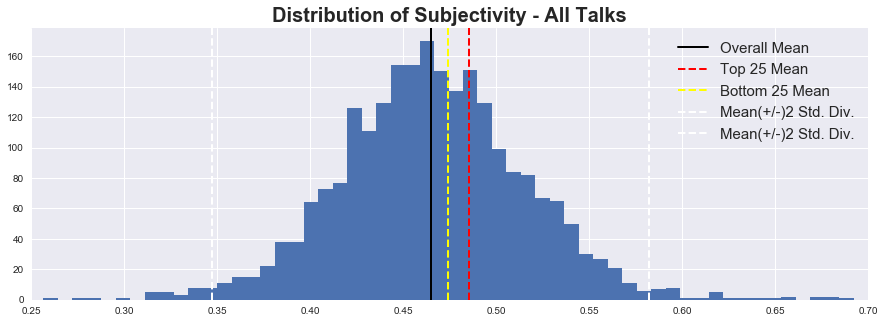

In [1295]:
SentimentDF.hist(column='Subjectivity', figsize=(15,5), bins=100)


mean = SentimentDF['Subjectivity'].mean()
top25mean= SentiTop25['Subjectivity'].mean()
Bot25mean= SentiBot25['Subjectivity'].mean()
stdiv = SentimentDF['Subjectivity'].std()

plt.axvline(mean, color='black', linestyle='solid', linewidth=2,label="Overall Mean")
plt.axvline(top25mean, color='red', linestyle='dashed', linewidth=2,label="Top 25 Mean")
plt.axvline(Bot25mean, color='yellow', linestyle='dashed', linewidth=2,label="Bottom 25 Mean")
plt.axvline(mean+2*stdiv, color='white', linestyle='dashed', linewidth=2,label="Mean(+/-)2 Std. Div.")
plt.axvline(mean-2*stdiv, color='white', linestyle='dashed', linewidth=2,label="Mean(+/-)2 Std. Div.")

plt.xlim(.25, .7)


plt.title('Distribution of Subjectivity - All Talks',fontsize=20,fontweight='bold')

leg = plt.legend(loc='upper right',fontsize = 15,fancybox=True)


plt.show()

##  Regression Analysis
### Determining impact of Topics on popularity of talks

#### Making DF with Topics added as Features


In [1126]:
SentimentDF.columns

Index(['id', 'speaker', 'headline', 'URL', 'description', 'month_filmed',
       'year_filmed', 'event', 'duration', 'date_published',
       'views_as_of_06162017', 'tags', 'transcript', 'Pub_Year', 'Pub_Month',
       'Polarity', 'Subjectivity'],
      dtype='object')

In [1127]:
FullDF = SentimentDF.filter(['id', 'speaker', 'headline', 'URL', 'description', 'month_filmed',
       'year_filmed', 'event', 'duration', 'date_published',
       'views_as_of_06162017', 'tags', 'transcript', 'Pub_Year', 'Pub_Month',
       'Polarity', 'Subjectivity'])

### Adding Topic Weights for all Documnets in a New Data Frame

In [1128]:
nmf_CountVec22

array([[ 0.00826979,  0.03476485,  0.00044537, ...,  0.00068919,
         0.00057192,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.09478817,
         0.        ,  0.        ],
       [ 0.01481014,  0.        ,  0.        , ...,  0.        ,
         0.00288549,  0.00454713],
       ..., 
       [ 0.04042769,  0.05121175,  0.        , ...,  0.        ,
         0.00916158,  0.        ],
       [ 0.03171475,  0.1009897 ,  0.        , ...,  0.01720529,
         0.        ,  0.        ],
       [ 0.01864497,  0.03426321,  0.0161424 , ...,  0.        ,
         0.00146996,  0.00483675]])

In [1129]:
nmf_CountVec22[0,0]

0.008269790298435999

In [1130]:
TopicDF= pd.DataFrame(nmf_CountVec22)

In [1131]:
TopicDF

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.008270,0.034765,0.000445,0.000000,0.014984,0.000000,0.000000,0.000142,0.009150,0.000000,...,0.136029,0.000000,0.014464,0.022651,0.000000,0.008573,0.013557,0.000689,0.000572,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023591,0.008350,0.000000,0.019879,...,0.067205,0.000584,0.033990,0.027621,0.000000,0.009079,0.000000,0.094788,0.000000,0.000000
2,0.014810,0.000000,0.000000,0.000000,0.051948,0.000000,0.002340,0.012770,0.011966,0.000000,...,0.017083,0.000000,0.015135,0.106595,0.000000,0.101283,0.000000,0.000000,0.002885,0.004547
3,0.000000,0.023955,0.000000,0.000577,0.014326,0.052068,0.000539,0.000000,0.014203,0.013423,...,0.032231,0.013317,0.065748,0.031011,0.000000,0.009957,0.000000,0.000000,0.001941,0.000000
4,0.018031,0.046126,0.000000,0.000000,0.000000,0.000000,0.000000,0.017032,0.031521,0.000000,...,0.060823,0.000000,0.084241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003206
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.004623,0.000000,0.000000,0.004447,0.000000,...,0.026032,0.000000,0.000000,0.000000,0.317541,0.000000,0.034043,0.007380,0.000000,0.000000
6,0.009682,0.032037,0.023205,0.000000,0.007648,0.000000,0.000000,0.000208,0.000000,0.000000,...,0.016265,0.000000,0.128248,0.011211,0.000808,0.002544,0.000000,0.000000,0.000000,0.000000
7,0.013890,0.019761,0.000000,0.000000,0.004908,0.000000,0.009192,0.000000,0.119937,0.000000,...,0.000000,0.000000,0.038327,0.000000,0.000000,0.000000,0.000330,0.000000,0.000000,0.000000
8,0.000000,0.030305,0.000000,0.000000,0.000000,0.000862,0.000000,0.000000,0.138184,0.000000,...,0.169211,0.005272,0.000000,0.000000,0.002066,0.027179,0.000000,0.028177,0.000000,0.000000
9,0.000000,0.000000,0.000209,0.000022,0.000000,0.000000,0.056495,0.000000,0.000000,0.008456,...,0.000000,0.000000,0.000000,0.040239,0.000000,0.028252,0.000000,0.029406,0.090709,0.005048


In [1132]:
topic_short

{0: 'Better Me',
 1: 'Stories Positivity',
 2: 'Music',
 3: 'Brain Unravel',
 4: 'Global Conflict',
 5: 'Life & Universe',
 6: 'Health Care',
 7: "Women's Issues",
 8: 'City Design',
 9: 'Child Issues',
 10: 'Space Exploration',
 11: 'Data Impact',
 12: 'Climate Change',
 13: 'Robotics/AI',
 14: 'Tech. Meet Art',
 15: 'Developing Nations Is.',
 16: 'Genetics',
 17: 'Global Economy',
 18: 'Marine World',
 19: 'Living Organisims',
 20: 'CancerResearch',
 21: 'Advances Medicine Sc.'}

In [1133]:
Heading=list(topic_short.values())

In [1134]:
TopicDF.columns = Heading

In [1135]:
TopicDF.head()

,Better Me,Stories Positivity,Music,Brain Unravel,Global Conflict,Life & Universe,Health Care,Women's Issues,City Design,Child Issues,...,Climate Change,Robotics/AI,Tech. Meet Art,Developing Nations Is.,Genetics,Global Economy,Marine World,Living Organisims,CancerResearch,Advances Medicine Sc.
0,0.008270,0.034765,0.000445,0.000000,0.014984,0.000000,0.000000,0.000142,0.009150,0.000000,...,0.136029,0.000000,0.014464,0.022651,0.0,0.008573,0.013557,0.000689,0.000572,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023591,0.008350,0.000000,0.019879,...,0.067205,0.000584,0.033990,0.027621,0.0,0.009079,0.000000,0.094788,0.000000,0.000000
2,0.014810,0.000000,0.000000,0.000000,0.051948,0.000000,0.002340,0.012770,0.011966,0.000000,...,0.017083,0.000000,0.015135,0.106595,0.0,0.101283,0.000000,0.000000,0.002885,0.004547
3,0.000000,0.023955,0.000000,0.000577,0.014326,0.052068,0.000539,0.000000,0.014203,0.013423,...,0.032231,0.013317,0.065748,0.031011,0.0,0.009957,0.000000,0.000000,0.001941,0.000000
4,0.018031,0.046126,0.000000,0.000000,0.000000,0.000000,0.000000,0.017032,0.031521,0.000000,...,0.060823,0.000000,0.084241,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.003206


### Merging TopicDF with FullDF 

In [1136]:
FullDF = pd.concat([FullDF, TopicDF], axis=1, join_axes=[FullDF.index])

In [1137]:
FullDF.head()

,id,speaker,headline,URL,description,month_filmed,year_filmed,event,duration,date_published,...,Climate Change,Robotics/AI,Tech. Meet Art,Developing Nations Is.,Genetics,Global Economy,Marine World,Living Organisims,CancerResearch,Advances Medicine Sc.
0,1.0,Al Gore,Averting the climate crisis,http://www.ted.com/talks/view/id/1,With the same humor and humanity he exuded in ...,2.0,2006.0,TED2006,0:16:17,2006-06-27,...,0.136029,0.000000,0.014464,0.022651,0.0,0.008573,0.013557,0.000689,0.000572,0.000000
1,2.0,Amy Smith,Simple designs to save a life,http://www.ted.com/talks/view/id/2,Fumes from indoor cooking fires kill more than...,2.0,2006.0,TED2006,0:15:06,2006-08-15,...,0.067205,0.000584,0.033990,0.027621,0.0,0.009079,0.000000,0.094788,0.000000,0.000000
2,3.0,Ashraf Ghani,How to rebuild a broken state,http://www.ted.com/talks/view/id/3,Ashraf Ghani's passionate and powerful 10-minu...,7.0,2005.0,TEDGlobal 2005,0:18:45,2006-10-18,...,0.017083,0.000000,0.015135,0.106595,0.0,0.101283,0.000000,0.000000,0.002885,0.004547
3,4.0,Burt Rutan,The real future of space exploration,http://www.ted.com/talks/view/id/4,"In this passionate talk, legendary spacecraft ...",2.0,2006.0,TED2006,0:19:37,2006-10-25,...,0.032231,0.013317,0.065748,0.031011,0.0,0.009957,0.000000,0.000000,0.001941,0.000000
4,5.0,Chris Bangle,Great cars are great art,http://www.ted.com/talks/view/id/5,American designer Chris Bangle explains his ph...,2.0,2002.0,TED2002,0:20:04,2007-04-05,...,0.060823,0.000000,0.084241,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.003206


Adding a Column for being Featured as Top 25 Most Popular on the TED Website

In [1138]:
IdTop25 = list(Top25['id'])   # Making a list of Ids for the top25 talks 

In [1139]:
FullDF['Featured_Top25'] = 0

In [1140]:
FullDF.columns[39]

'Featured_Top25'

In [1141]:
for index, row in FullDF.iterrows():
    if FullDF.iloc[index,0] in IdTop25:
        FullDF.iloc[index,39]= 1   #Assigning 1 to those talk that are present in IdTop25 list

In [1142]:
FullDF[FullDF['Featured_Top25']==1]

,id,speaker,headline,URL,description,month_filmed,year_filmed,event,duration,date_published,...,Robotics/AI,Tech. Meet Art,Developing Nations Is.,Genetics,Global Economy,Marine World,Living Organisims,CancerResearch,Advances Medicine Sc.,Featured_Top25
61,66.0,Ken Robinson,Do schools kill creativity?,http://www.ted.com/talks/view/id/66,Sir Ken Robinson makes an entertaining and pro...,2.0,2006.0,TED2006,0:19:24,2006-06-27,...,0.000000,0.013234,0.000000,0.000000,0.011506,0.000000,0.001662,0.001386,0.003380,1
89,96.0,Tony Robbins,Why we do what we do,http://www.ted.com/talks/view/id/96,"Tony Robbins discusses the ""invisible forces"" ...",2.0,2006.0,TED2006,0:21:45,2006-06-27,...,0.000000,0.000424,0.027313,0.000000,0.009836,0.000000,0.012018,0.013217,0.000000,1
90,97.0,Dan Gilbert,The surprising science of happiness,http://www.ted.com/talks/view/id/97,"Dan Gilbert, author of ""Stumbling on Happiness...",2.0,2004.0,TED2004,0:21:16,2006-09-26,...,0.000000,0.003041,0.000000,0.000351,0.000000,0.000000,0.000000,0.001063,0.000926,1
179,206.0,David Gallo,Underwater astonishments,http://www.ted.com/talks/view/id/206,David Gallo shows jaw-dropping footage of amaz...,3.0,2007.0,TED2007,0:05:27,2008-01-11,...,0.001735,0.026470,0.000000,0.000000,0.000000,0.115268,0.018073,0.000000,0.004680,1
201,229.0,Jill Bolte Taylor,My stroke of insight,http://www.ted.com/talks/view/id/229,Jill Bolte Taylor got a research opportunity f...,2.0,2008.0,TED2008,0:18:19,2008-03-12,...,0.000044,0.007905,0.000000,0.000000,0.000000,0.000000,0.000000,0.002745,0.018045,1
260,310.0,Keith Barry,Brain magic,http://www.ted.com/talks/view/id/310,"First, Keith Barry shows us how our brains can...",2.0,2004.0,TED2004,0:19:49,2008-07-18,...,0.000597,0.014781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
369,453.0,Elizabeth Gilbert,Your elusive creative genius,http://www.ted.com/talks/view/id/453,Elizabeth Gilbert muses on the impossible thin...,2.0,2009.0,TED2009,0:19:09,2009-02-09,...,0.000000,0.041258,0.000000,0.000394,0.000000,0.000000,0.000000,0.000000,0.000126,1
438,549.0,Mary Roach,10 things you didn't know about orgasm,http://www.ted.com/talks/view/id/549,"""Bonk"" author Mary Roach delves into obscure s...",2.0,2009.0,TED2009,0:16:43,2009-05-20,...,0.004691,0.018825,0.000000,0.001518,0.000000,0.001655,0.012354,0.002992,0.009017,1
485,618.0,Dan Pink,The puzzle of motivation,http://www.ted.com/talks/view/id/618,Career analyst Dan Pink examines the puzzle of...,7.0,2009.0,TEDGlobal 2009,0:18:36,2009-08-24,...,0.005448,0.045585,0.025277,0.000000,0.000796,0.000115,0.000000,0.000274,0.000000,1
514,652.0,Chimamanda Ngozi Adichie,The danger of a single story,http://www.ted.com/talks/view/id/652,"Our lives, our cultures, are composed of many ...",7.0,2009.0,TEDGlobal 2009,0:18:49,2009-10-07,...,0.000000,0.000000,0.165185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1


 Adding a Columns for Top Topic No. & Top Topic Name to FullDF


In [1143]:
FullDF['Top_Topic']= DocTopicList22

Adding another column with Top Topic Name  to FullDF

In [1144]:
DocTopic_Names22 = Top_NMF_Frame22['TopicName']

In [1145]:
FullDF['Top_TopicName']=DocTopic_Names22

In [1146]:
FullDF.head()

,id,speaker,headline,URL,description,month_filmed,year_filmed,event,duration,date_published,...,Developing Nations Is.,Genetics,Global Economy,Marine World,Living Organisims,CancerResearch,Advances Medicine Sc.,Featured_Top25,Top_Topic,Top_TopicName
0,1.0,Al Gore,Averting the climate crisis,http://www.ted.com/talks/view/id/1,With the same humor and humanity he exuded in ...,2.0,2006.0,TED2006,0:16:17,2006-06-27,...,0.022651,0.0,0.008573,0.013557,0.000689,0.000572,0.000000,0,12,Climate Change
1,2.0,Amy Smith,Simple designs to save a life,http://www.ted.com/talks/view/id/2,Fumes from indoor cooking fires kill more than...,2.0,2006.0,TED2006,0:15:06,2006-08-15,...,0.027621,0.0,0.009079,0.000000,0.094788,0.000000,0.000000,0,19,Living Organisims
2,3.0,Ashraf Ghani,How to rebuild a broken state,http://www.ted.com/talks/view/id/3,Ashraf Ghani's passionate and powerful 10-minu...,7.0,2005.0,TEDGlobal 2005,0:18:45,2006-10-18,...,0.106595,0.0,0.101283,0.000000,0.000000,0.002885,0.004547,0,15,Developing Nations Is.
3,4.0,Burt Rutan,The real future of space exploration,http://www.ted.com/talks/view/id/4,"In this passionate talk, legendary spacecraft ...",2.0,2006.0,TED2006,0:19:37,2006-10-25,...,0.031011,0.0,0.009957,0.000000,0.000000,0.001941,0.000000,0,14,Tech. Meet Art
4,5.0,Chris Bangle,Great cars are great art,http://www.ted.com/talks/view/id/5,American designer Chris Bangle explains his ph...,2.0,2002.0,TED2002,0:20:04,2007-04-05,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.003206,0,14,Tech. Meet Art


### Analyzing Top25 & Bottom25 on all Topic Wts assigned to a Talk and not just the Top Topic

For the top 25 and bottom 25 talks, first adding topic wts for all 22 Topics and then averaging it

Create seperate DFs for Top and Bottom 25 and add a Col Indicating Top or Bottom

In [1147]:
WtTop25 = FullDF.sort_values(by=['views_as_of_06162017'],ascending=False).head(25)

In [1148]:
WtTop25['Popularity']='Top25'

In [1149]:
WtBot25 = FullDF.sort_values(by=['views_as_of_06162017'],ascending=True).head(25)

In [1150]:
FullDF.columns

Index(['id', 'speaker', 'headline', 'URL', 'description', 'month_filmed',
       'year_filmed', 'event', 'duration', 'date_published',
       'views_as_of_06162017', 'tags', 'transcript', 'Pub_Year', 'Pub_Month',
       'Polarity', 'Subjectivity', 'Better Me', 'Stories Positivity', 'Music',
       'Brain Unravel', 'Global Conflict', 'Life & Universe', 'Health Care',
       'Women's Issues', 'City Design', 'Child Issues', 'Space Exploration',
       'Data Impact', 'Climate Change', 'Robotics/AI', 'Tech. Meet Art',
       'Developing Nations Is.', 'Genetics', 'Global Economy', 'Marine World',
       'Living Organisims', 'CancerResearch', 'Advances Medicine Sc.',
       'Featured_Top25', 'Top_Topic', 'Top_TopicName'],
      dtype='object')

In [1151]:
WtBot25['Popularity']='Bottom25'

Concatenating the Top & Botom Df

In [1152]:
WtTopBot25 = pd.concat([WtTop25,WtBot25])

In [1153]:
WtTopBot25.shape

(50, 43)

In [1154]:
WtTopBot25.columns

Index(['id', 'speaker', 'headline', 'URL', 'description', 'month_filmed',
       'year_filmed', 'event', 'duration', 'date_published',
       'views_as_of_06162017', 'tags', 'transcript', 'Pub_Year', 'Pub_Month',
       'Polarity', 'Subjectivity', 'Better Me', 'Stories Positivity', 'Music',
       'Brain Unravel', 'Global Conflict', 'Life & Universe', 'Health Care',
       'Women's Issues', 'City Design', 'Child Issues', 'Space Exploration',
       'Data Impact', 'Climate Change', 'Robotics/AI', 'Tech. Meet Art',
       'Developing Nations Is.', 'Genetics', 'Global Economy', 'Marine World',
       'Living Organisims', 'CancerResearch', 'Advances Medicine Sc.',
       'Featured_Top25', 'Top_Topic', 'Top_TopicName', 'Popularity'],
      dtype='object')

###  Topic Weights Comparision- Top & Bottom 25  
(Averaging this would not change the values as it would divided all by 50..and the comparison results would remain same)

In [1339]:
WtPivotTopBot25 = WtTopBot25.pivot_table(index="Popularity",values=['Better Me', 'Stories Positivity', 'Music',
       'Brain Unravel', 'Global Conflict', 'Life & Universe', 'Health Care',
       'Women\'s Issues', 'City Design', 'Child Issues', 'Space Exploration',
       'Data Impact', 'Climate Change', 'Robotics/AI', 'Tech. Meet Art',
       'Developing Nations Is.', 'Genetics', 'Global Economy', 'Marine World',
       'Living Organisims', 'CancerResearch', 'Advances Medicine Sc.'],aggfunc=lambda x: x.mean())

In [1340]:
WtPivotTopBot25

,Advances Medicine Sc.,Better Me,Brain Unravel,CancerResearch,Child Issues,City Design,Climate Change,Data Impact,Developing Nations Is.,Genetics,...,Health Care,Life & Universe,Living Organisims,Marine World,Music,Robotics/AI,Space Exploration,Stories Positivity,Tech. Meet Art,Women's Issues
Popularity,,,,,,,,,,,,,,,,,,,,,
Bottom25,0.001925,0.017721,0.000895,0.001053,0.006114,0.004234,0.014375,0.006477,0.020690,0.003505,...,0.013530,0.005903,0.016426,0.017883,0.002885,0.001625,0.008998,0.024340,0.032411,0.004954
Top25,0.002882,0.032480,0.014940,0.001431,0.011996,0.001041,0.006004,0.005759,0.012223,0.000251,...,0.008057,0.001624,0.003052,0.006163,0.002615,0.001468,0.001610,0.038692,0.022811,0.006780


#### Comparing Top 25 talks with Bottom 25 talks on all topic weights

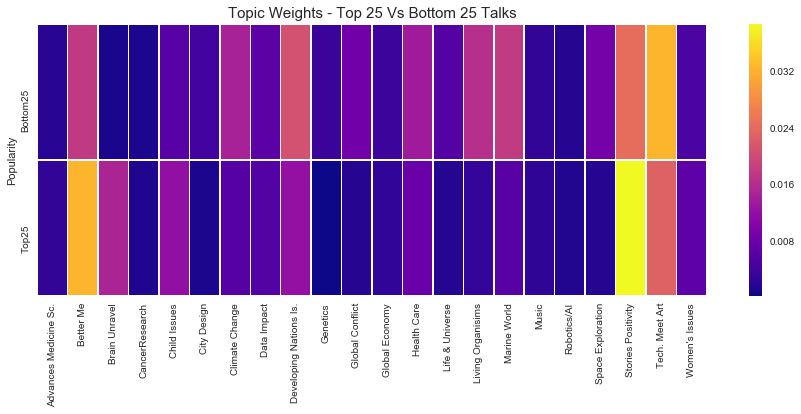

In [1336]:
fig, ax = plt.subplots(figsize=(15,5))
plt.title('Topic Weights - Top 25 Vs Bottom 25 Talks',size=15)
sns.heatmap(WtPivotTopBot25, cmap=cm.plasma, linewidths=.5, ax=ax);

### Topic Wise Sentiment Anlysis

In [1162]:
PolarityPivotTopBot25 = WtTopBot25.pivot_table(index="Popularity",columns=['Top_TopicName'],values='Polarity',aggfunc=lambda x: x.mean())

In [1164]:
PolarityPivotTopBot25

Top_TopicName,Better Me,Brain Unravel,Child Issues,Climate Change,Data Impact,Developing Nations Is.,Global Conflict,Health Care,Living Organisims,Marine World,Space Exploration,Stories Positivity,Tech. Meet Art,Women's Issues
Popularity,,,,,,,,,,,,,,
Bottom25,0.152094,NaN,NaN,0.116792,0.176802,0.163718,0.067714,0.122166,0.150815,0.084020,0.12418,0.104762,0.139909,NaN
Top25,0.151957,0.154841,0.142933,NaN,NaN,0.126963,NaN,0.173056,NaN,0.202444,NaN,0.112724,0.149425,0.160175


# Add

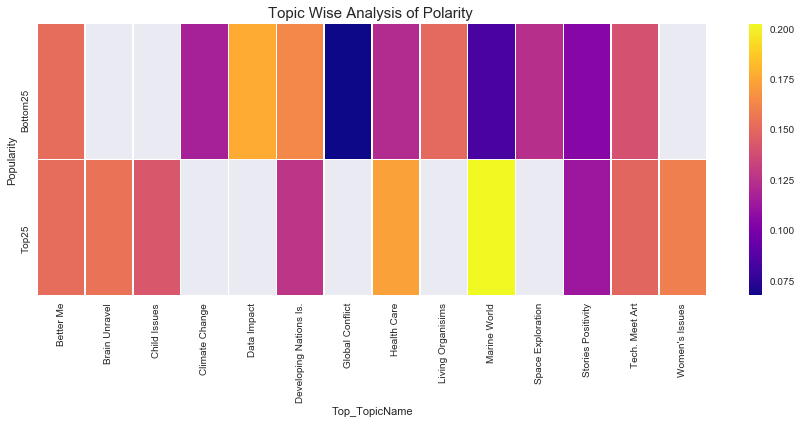

In [1165]:
fig, ax = plt.subplots(figsize=(15,5))
plt.title('Topic Wise Analysis of Polarity ',size=15)
sns.heatmap(PolarityPivotTopBot25, cmap=cm.plasma, linewidths=.5, ax=ax);

## Regression Anlysis

In [1193]:
FullDF.columns

Index(['id', 'speaker', 'headline', 'URL', 'description', 'month_filmed',
       'year_filmed', 'event', 'duration', 'date_published',
       'views_as_of_06162017', 'tags', 'transcript', 'Pub_Year', 'Pub_Month',
       'Polarity', 'Subjectivity', 'Better Me', 'Stories Positivity', 'Music',
       'Brain Unravel', 'Global Conflict', 'Life & Universe', 'Health Care',
       'Women's Issues', 'City Design', 'Child Issues', 'Space Exploration',
       'Data Impact', 'Climate Change', 'Robotics/AI', 'Tech. Meet Art',
       'Developing Nations Is.', 'Genetics', 'Global Economy', 'Marine World',
       'Living Organisims', 'CancerResearch', 'Advances Medicine Sc.',
       'Featured_Top25', 'Top_Topic', 'Top_TopicName'],
      dtype='object')

In [1201]:
FullDF.loc[:,['views_as_of_06162017','Pub_Year',
       'Polarity', 'Subjectivity', 'Better Me', 'Stories Positivity', 'Music',
       'Brain Unravel', 'Global Conflict', 'Life & Universe', 'Health Care',
       'Women\'s Issues', 'City Design', 'Child Issues', 'Space Exploration',
       'Data Impact', 'Climate Change', 'Robotics/AI', 'Tech. Meet Art',
       'Developing Nations Is.', 'Genetics', 'Global Economy', 'Marine World',
       'Living Organisims', 'CancerResearch', 'Advances Medicine Sc.','Featured_Top25']].head()

,views_as_of_06162017,Pub_Year,Polarity,Subjectivity,Better Me,Stories Positivity,Music,Brain Unravel,Global Conflict,Life & Universe,...,Robotics/AI,Tech. Meet Art,Developing Nations Is.,Genetics,Global Economy,Marine World,Living Organisims,CancerResearch,Advances Medicine Sc.,Featured_Top25
0,3177001.0,2006,0.161357,0.429476,0.008270,0.034765,0.000445,0.000000,0.014984,0.000000,...,0.000000,0.014464,0.022651,0.0,0.008573,0.013557,0.000689,0.000572,0.000000,0
1,1379328.0,2006,0.118173,0.490973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000584,0.033990,0.027621,0.0,0.009079,0.000000,0.094788,0.000000,0.000000,0
2,790536.0,2006,0.094298,0.472470,0.014810,0.000000,0.000000,0.000000,0.051948,0.000000,...,0.000000,0.015135,0.106595,0.0,0.101283,0.000000,0.000000,0.002885,0.004547,0
3,1985119.0,2006,0.172714,0.412625,0.000000,0.023955,0.000000,0.000577,0.014326,0.052068,...,0.013317,0.065748,0.031011,0.0,0.009957,0.000000,0.000000,0.001941,0.000000,0
4,859487.0,2007,0.207904,0.488787,0.018031,0.046126,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.084241,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.003206,0


Viewership is right tailed, so take a log 

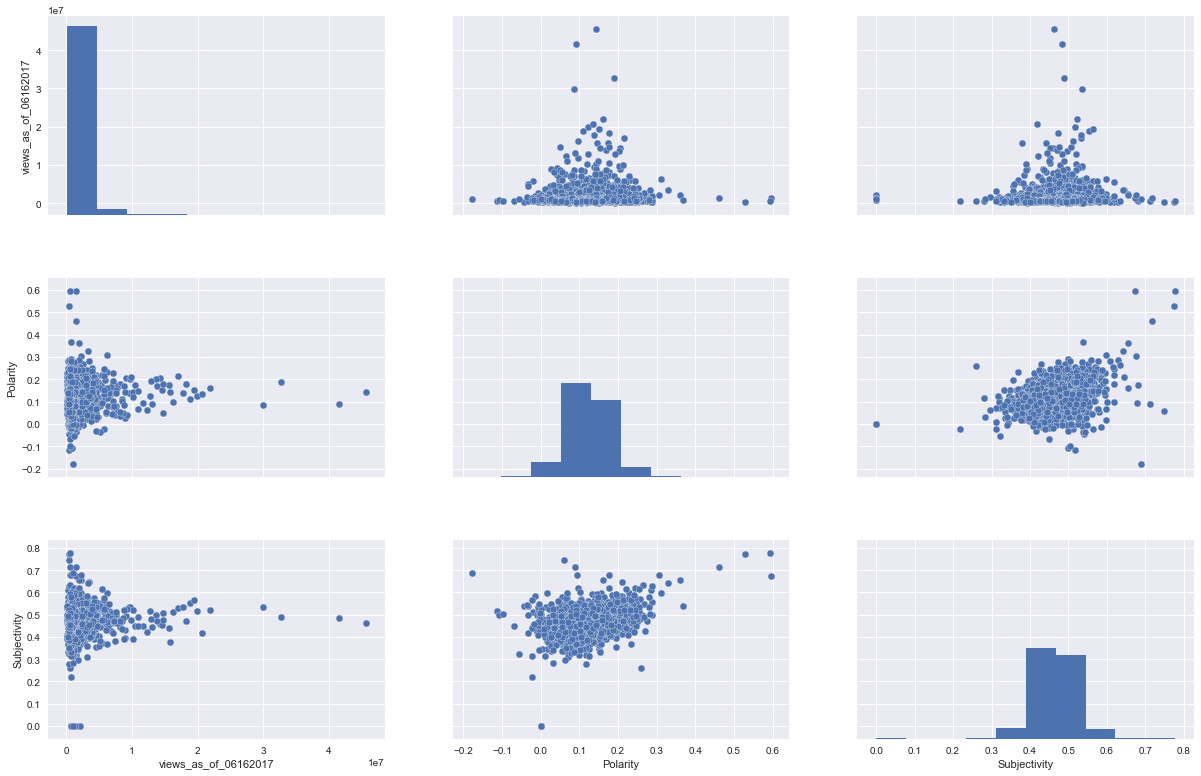

In [1204]:
sns.pairplot(FullDF.loc[:,['views_as_of_06162017',
       'Polarity', 'Subjectivity']], size = 4, aspect=1.5)

Not including featured in Top25, as this feature appeared after viewership grew

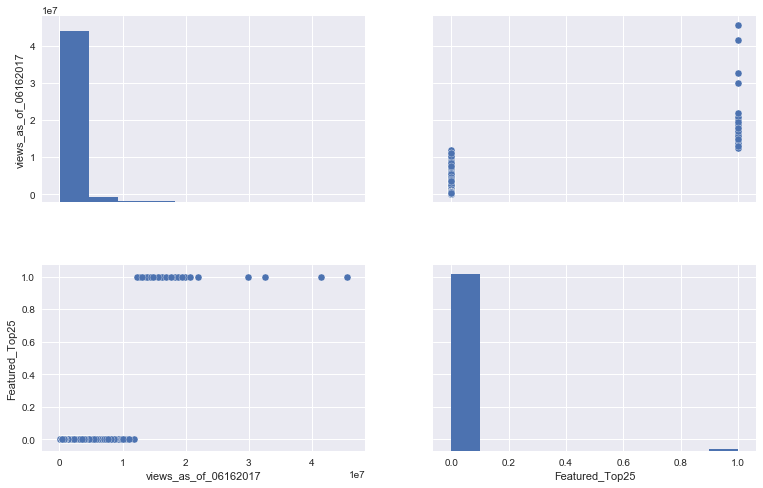

In [1205]:
sns.pairplot(FullDF.loc[:,['views_as_of_06162017','Featured_Top25']], size = 4, aspect=1.5)

Take out year of publication

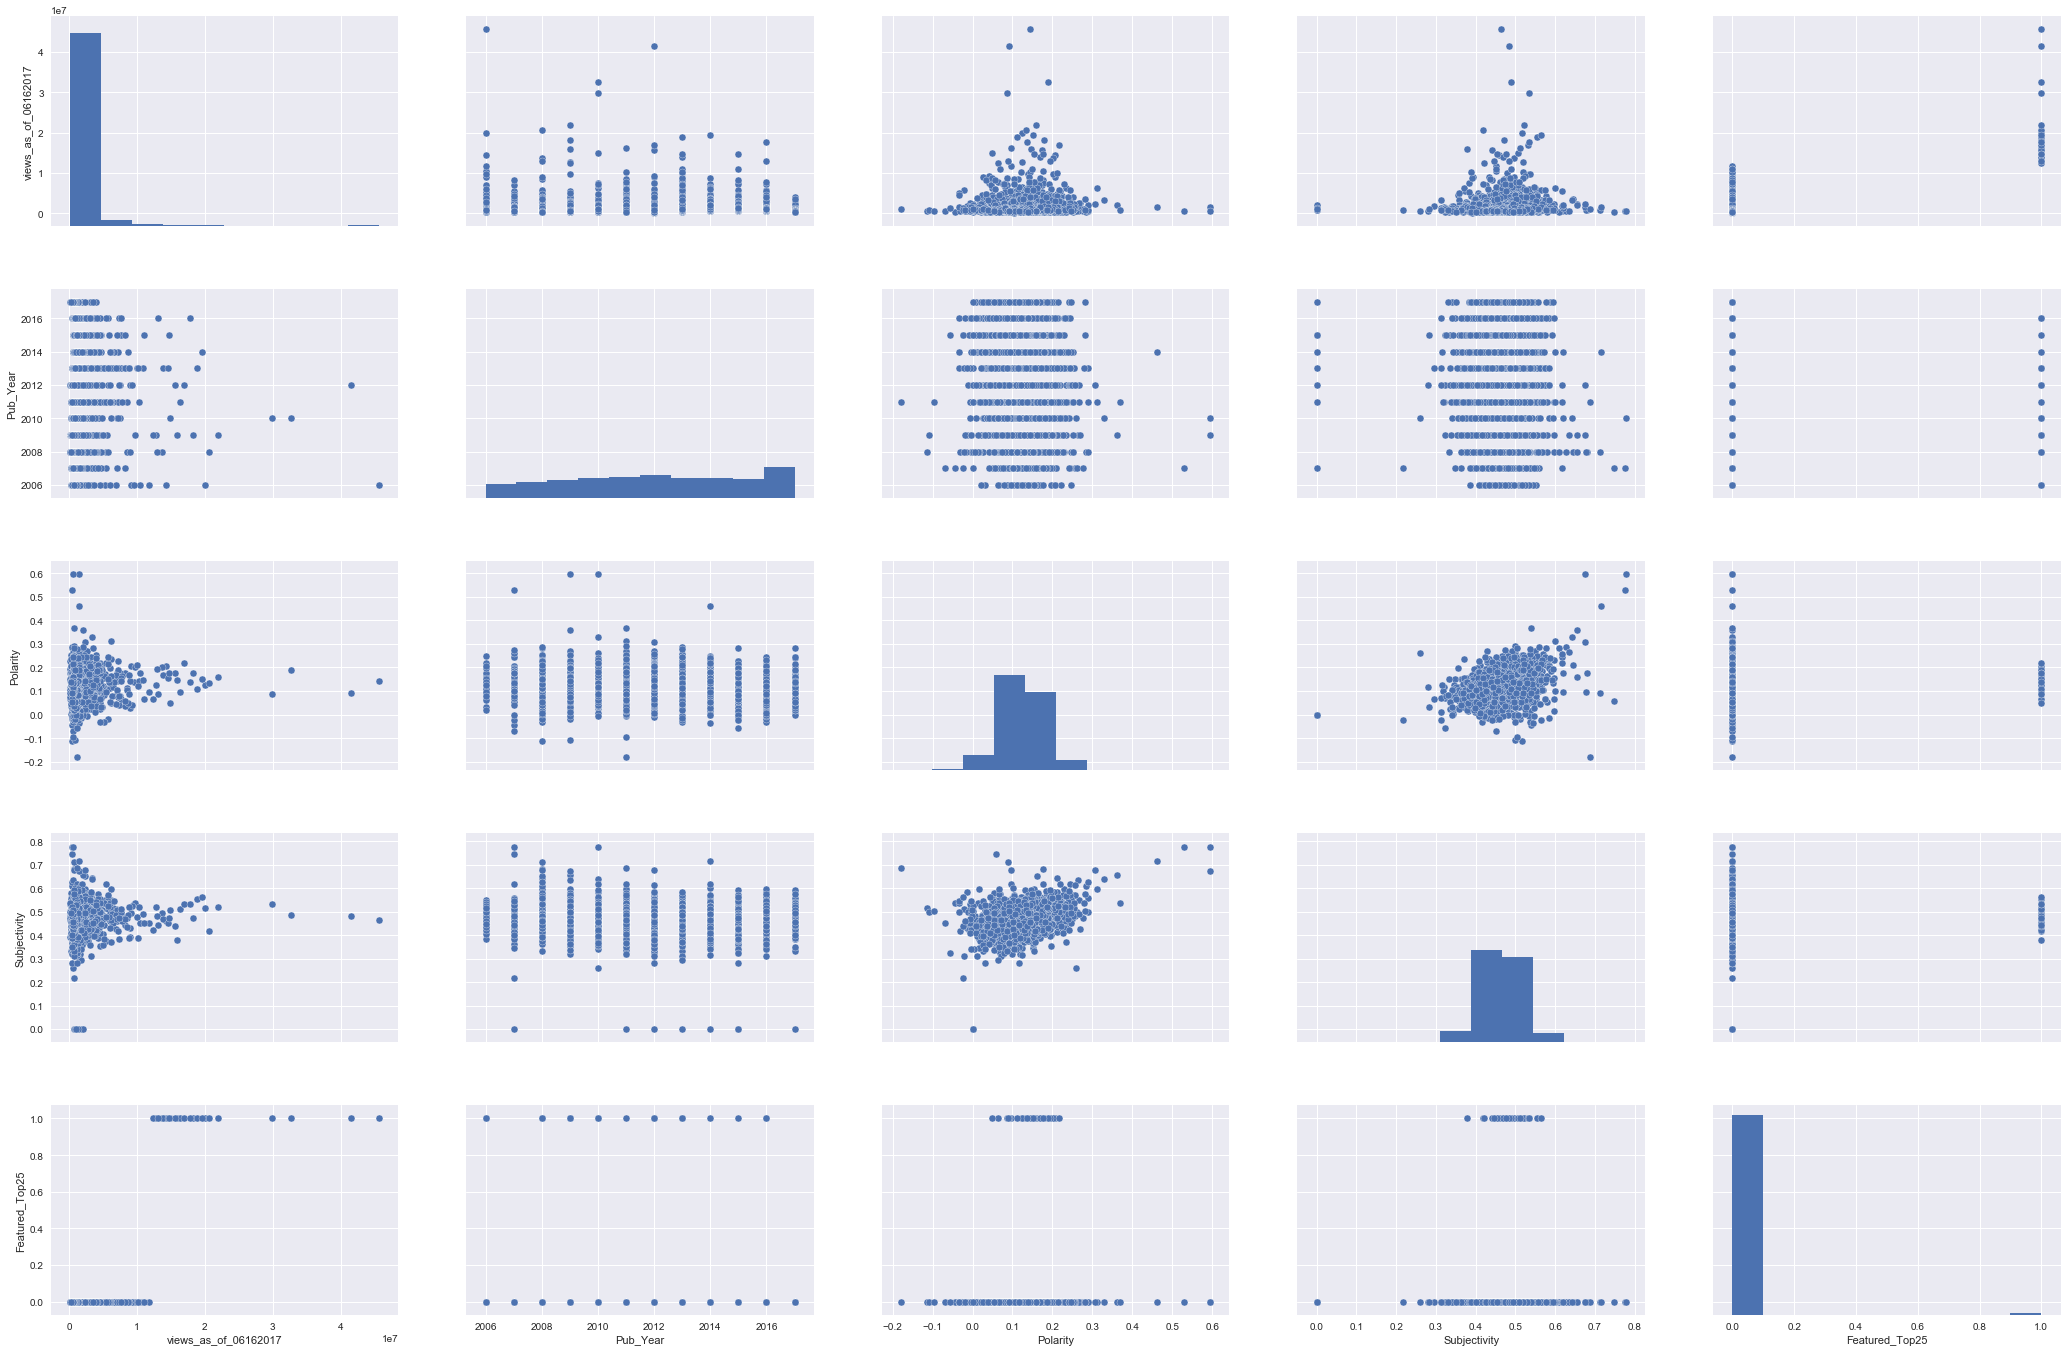

In [1203]:
sns.pairplot(FullDF.loc[:,['views_as_of_06162017','Pub_Year',
       'Polarity', 'Subjectivity','Featured_Top25']], size = 4, aspect=1.5)

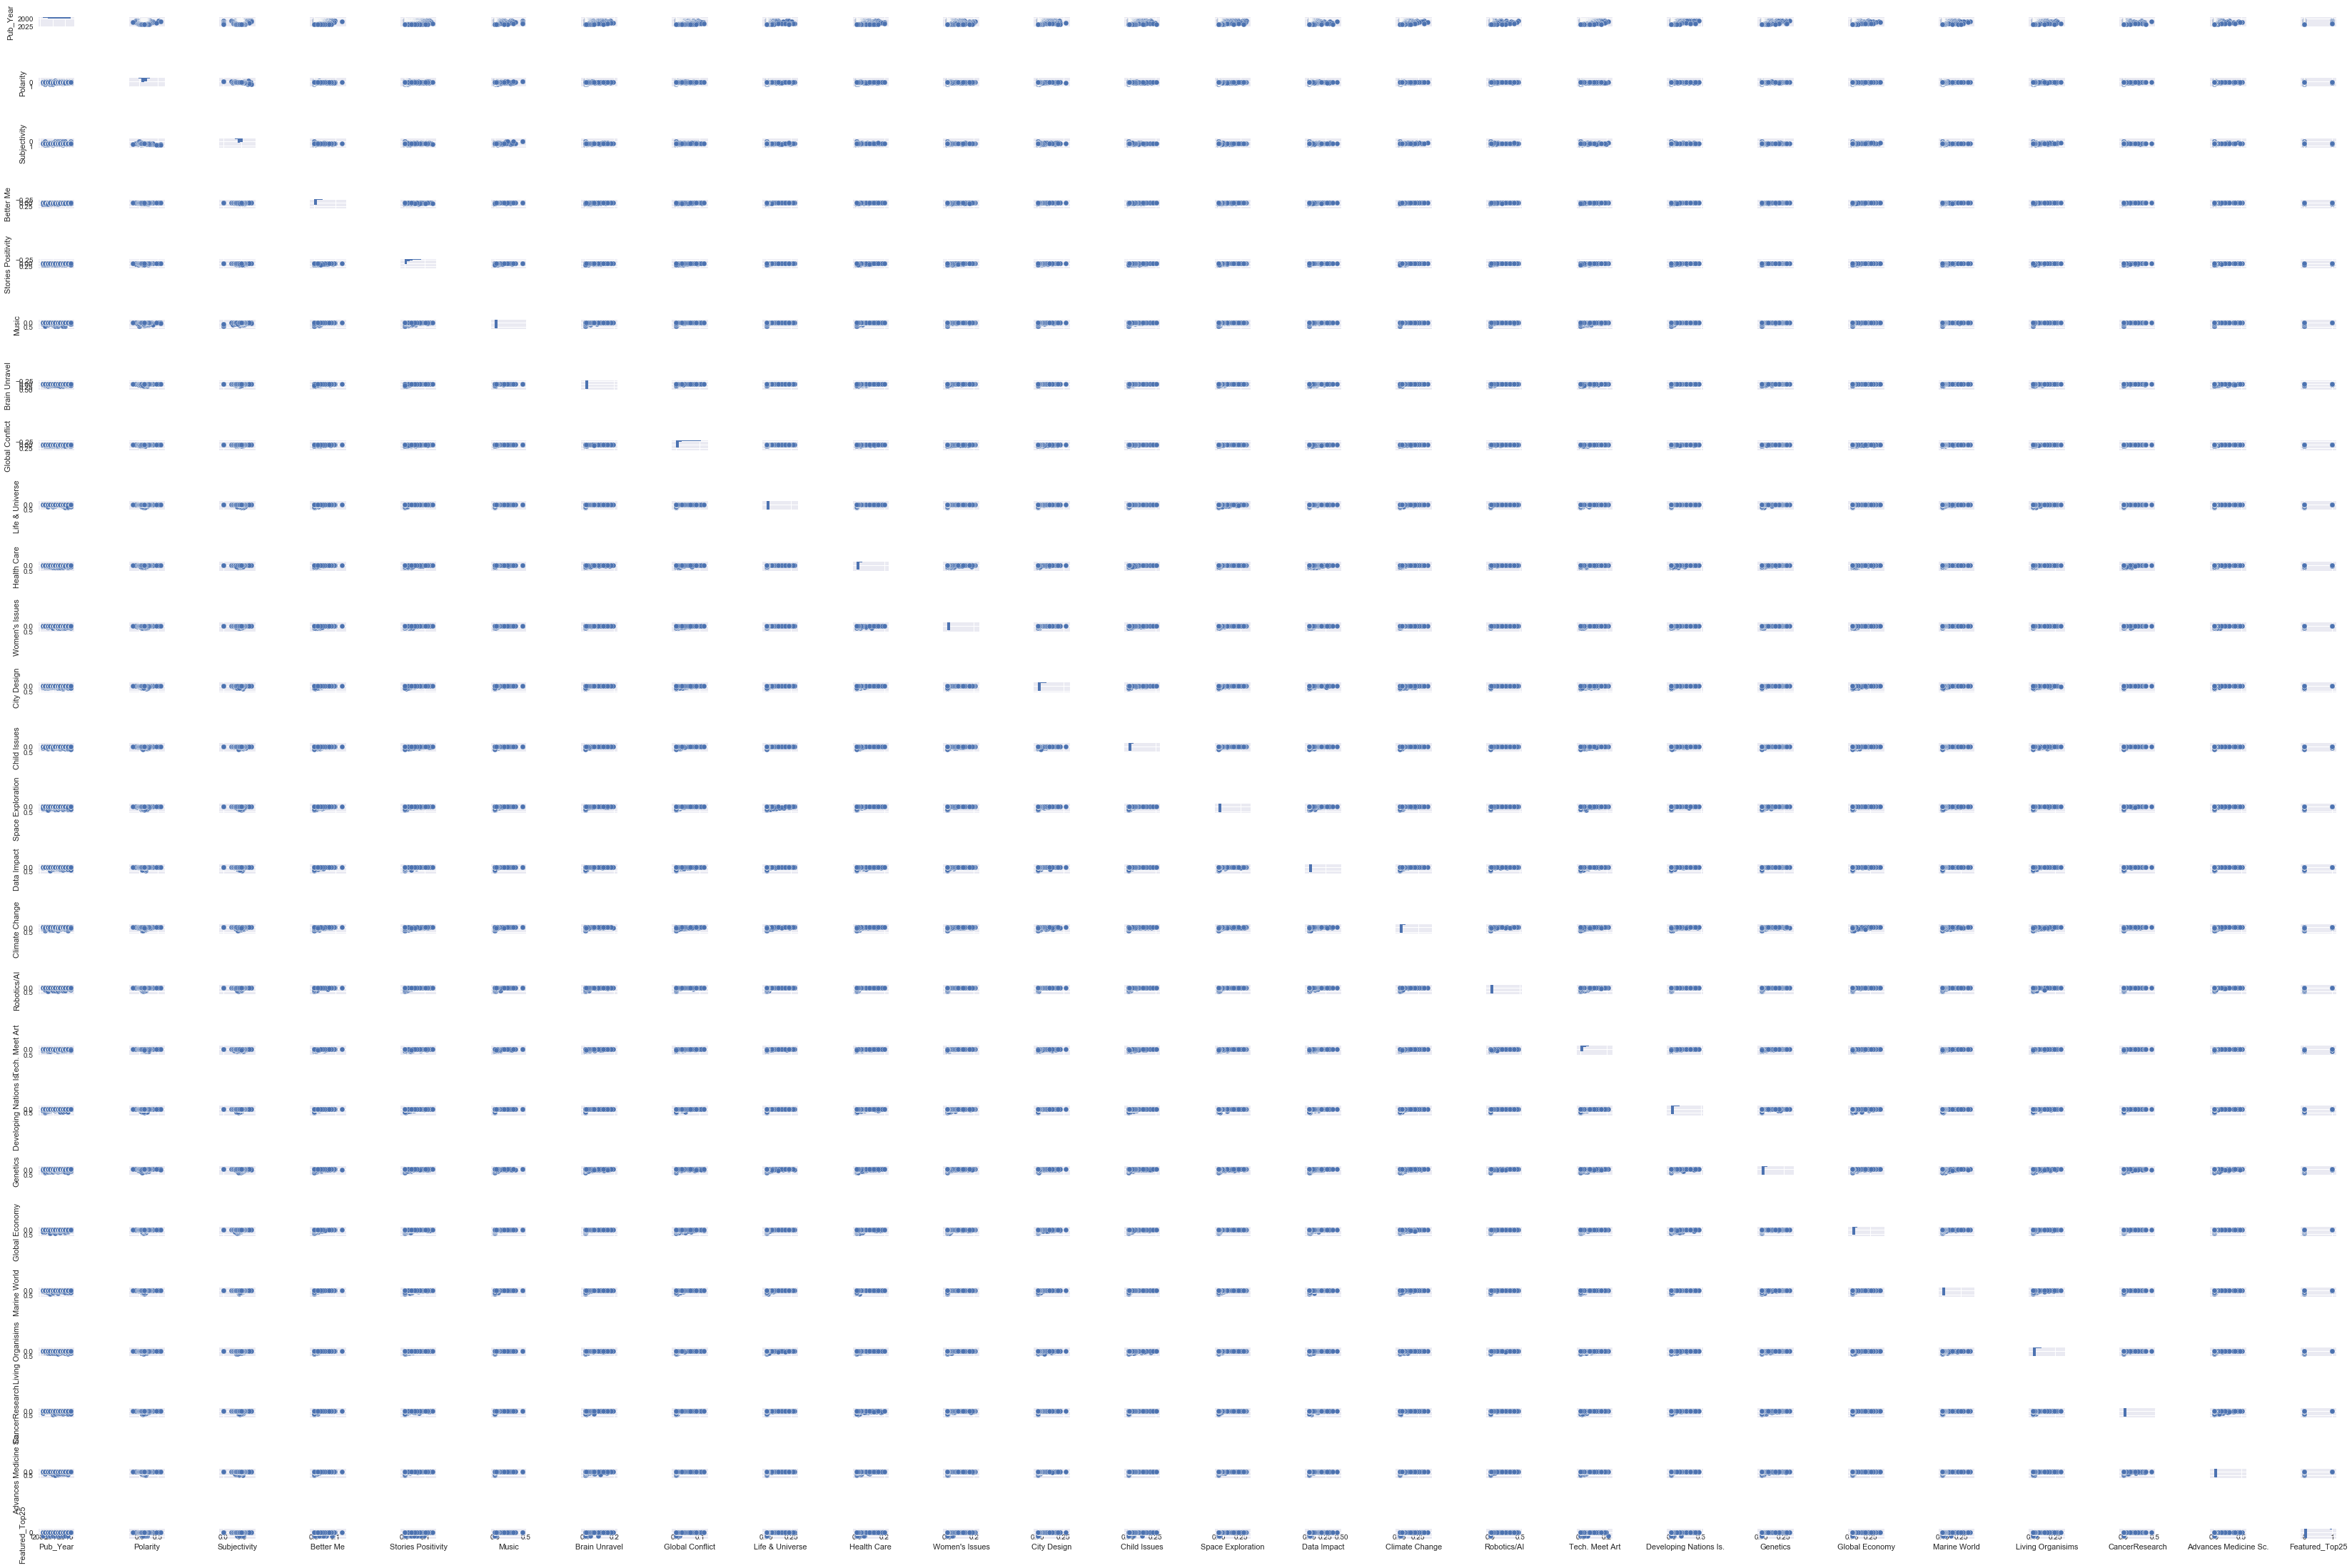

In [1200]:
sns.pairplot(FullDF.loc[:,['Pub_Year',
       'Polarity', 'Subjectivity', 'Better Me', 'Stories Positivity', 'Music',
       'Brain Unravel', 'Global Conflict', 'Life & Universe', 'Health Care',
       'Women\'s Issues', 'City Design', 'Child Issues', 'Space Exploration',
       'Data Impact', 'Climate Change', 'Robotics/AI', 'Tech. Meet Art',
       'Developing Nations Is.', 'Genetics', 'Global Economy', 'Marine World',
       'Living Organisims', 'CancerResearch', 'Advances Medicine Sc.','Featured_Top25']], size = 1.2, aspect=1.5)

In [1207]:
FullDF['LogViews']= np.log(FullDF['views_as_of_06162017'])

## LassoCV Regression

In [1211]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

/Users/sdutta/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [1246]:
X = FullDF.loc[:,['Polarity', 'Subjectivity', 'Better Me', 'Stories Positivity', 'Music',
       'Brain Unravel', 'Global Conflict', 'Life & Universe', 'Health Care',
       'Women\'s Issues', 'City Design', 'Child Issues', 'Space Exploration',
       'Data Impact', 'Climate Change', 'Robotics/AI', 'Tech. Meet Art',
       'Developing Nations Is.', 'Genetics', 'Global Economy', 'Marine World',
       'Living Organisims', 'CancerResearch', 'Advances Medicine Sc.']]

y=FullDF.loc[:,'LogViews']
y=y.reshape(2386,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

/Users/sdutta/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


#### Method 1 - Get Best Alpha

In [1347]:
# Another way to do Lasso with CV. This method chooses the best alpha to conduct CV
lcv = LassoCV(alphas=np.logspace(-10,1,num=50), cv=10,normalize=True )
lcv.fit(X_train,y_train)  # No need to split the data as LassoCV does the splitting on its own for CV
print(lcv.score(X_test,y_test))
print(lcv.alpha_)    # The alpha or amount of penalization choosen by CV 
print(list(zip(lcv.coef_, X.columns)))
print(lcv.intercept_)

0.0870449883283
0.000193069772888
[(0.0, 'Polarity'), (0.29049198339795457, 'Subjectivity'), (8.5887056638891792, 'Better Me'), (3.399372132588065, 'Stories Positivity'), (0.34718638035232796, 'Music'), (2.8229305907585895, 'Brain Unravel'), (-3.4980233719189688, 'Global Conflict'), (-0.0, 'Life & Universe'), (-1.9051854491525206, 'Health Care'), (-0.11260970462645943, "Women's Issues"), (-1.6754670313193858, 'City Design'), (1.9864624774846809, 'Child Issues'), (-0.0, 'Space Exploration'), (0.073656768913589882, 'Data Impact'), (0.0, 'Climate Change'), (0.398794122890339, 'Robotics/AI'), (-1.0779074208615513, 'Tech. Meet Art'), (-1.4068488998006516, 'Developing Nations Is.'), (-0.97516278104648457, 'Genetics'), (0.33507726036065105, 'Global Economy'), (-1.4494576242430788, 'Marine World'), (0.0, 'Living Organisims'), (-0.0, 'CancerResearch'), (0.061079116265981816, 'Advances Medicine Sc.')]
13.7752669949


/Users/sdutta/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  model_str = 'ElasticNet'


In [1421]:
listCoeff= [(0.0, 'Polarity'), (0.29049198339795457, 'Subjectivity'), (8.5887056638891792, 'Better Me'), \
            (3.399372132588065, 'Stories Positivity'), (0.34718638035232796, 'Music'), (2.8229305907585895, \
            'Brain Unravel'), (-3.4980233719189688, 'Global Conflict'), (-0.0, 'Life & Universe'), \
            (-1.9051854491525206, 'Health Care'), (-0.11260970462645943, "Women's Issues"), \
            (-1.6754670313193858, 'City Design'), (1.9864624774846809, 'Child Issues'), \
            (-0.0, 'Space Exploration'), (0.073656768913589882, 'Data Impact'), (0.0, 'Climate Change'), \
            (0.398794122890339, 'Robotics/AI'), (-1.0779074208615513, 'Tech. Meet Art'),\
            (-1.4068488998006516, 'Developing Nations Is.'), (-0.97516278104648457, 'Genetics'), 
            (0.33507726036065105, 'Global Economy'), (-1.4494576242430788, 'Marine World'), \
            (0.0, 'Living Organisims'), (-0.0, 'CancerResearch'), (0.061079116265981816, 'Advances Medicine Sc.')]






In [1424]:
listCoeff.sort(key=lambda x: x[0], reverse=True)

In [1426]:
[print(x[1],': ',x[0]) for x in listCoeff]

Better Me :  8.58870566388918
Stories Positivity :  3.399372132588065
Brain Unravel :  2.8229305907585895
Child Issues :  1.9864624774846809
Robotics/AI :  0.398794122890339
Music :  0.34718638035232796
Global Economy :  0.33507726036065105
Subjectivity :  0.29049198339795457
Data Impact :  0.07365676891358988
Advances Medicine Sc. :  0.061079116265981816
Polarity :  0.0
Life & Universe :  -0.0
Space Exploration :  -0.0
Climate Change :  0.0
Living Organisims :  0.0
CancerResearch :  -0.0
Women's Issues :  -0.11260970462645943
Genetics :  -0.9751627810464846
Tech. Meet Art :  -1.0779074208615513
Developing Nations Is. :  -1.4068488998006516
Marine World :  -1.4494576242430788
City Design :  -1.6754670313193858
Health Care :  -1.9051854491525206
Global Conflict :  -3.498023371918969


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [1344]:
np.logspace(-3,0,50)

array([ 0.001     ,  0.0011514 ,  0.00132571,  0.00152642,  0.00175751,
        0.00202359,  0.00232995,  0.0026827 ,  0.00308884,  0.00355648,
        0.00409492,  0.00471487,  0.00542868,  0.00625055,  0.00719686,
        0.00828643,  0.00954095,  0.01098541,  0.01264855,  0.01456348,
        0.01676833,  0.01930698,  0.02222996,  0.02559548,  0.02947052,
        0.03393222,  0.0390694 ,  0.04498433,  0.05179475,  0.05963623,
        0.06866488,  0.07906043,  0.09102982,  0.10481131,  0.12067926,
        0.13894955,  0.15998587,  0.184207  ,  0.21209509,  0.24420531,
        0.28117687,  0.32374575,  0.37275937,  0.42919343,  0.49417134,
        0.5689866 ,  0.65512856,  0.75431201,  0.86851137,  1.        ])

In [1248]:
X.corr()

,Polarity,Subjectivity,Better Me,Stories Positivity,Music,Brain Unravel,Global Conflict,Life & Universe,Health Care,Women's Issues,...,Climate Change,Robotics/AI,Tech. Meet Art,Developing Nations Is.,Genetics,Global Economy,Marine World,Living Organisims,CancerResearch,Advances Medicine Sc.
Polarity,1.000000,0.364192,0.082948,-0.065119,0.013316,-0.007782,-0.177413,0.005753,-0.063811,0.001369,...,0.016987,0.003548,0.163501,-0.014404,-0.056598,-0.016332,-0.031592,-0.009363,-0.019076,-0.007865
Subjectivity,0.364192,1.000000,0.114540,0.146874,-0.235967,-0.016889,-0.111206,0.039346,-0.046267,0.016871,...,-0.059244,-0.029281,0.030115,-0.098251,-0.000355,-0.178320,-0.015030,-0.040143,0.011706,-0.018555
Better Me,0.082948,0.114540,1.000000,-0.041521,-0.055040,0.034289,-0.037765,-0.065334,-0.056944,-0.007495,...,-0.078027,-0.051694,-0.091540,-0.041857,-0.043950,-0.016260,-0.102822,-0.115849,-0.063117,-0.078386
Stories Positivity,-0.065119,0.146874,-0.041521,1.000000,-0.008714,-0.094049,-0.074722,-0.085433,-0.077160,0.064749,...,-0.146469,-0.073123,-0.111115,-0.089154,-0.146091,-0.118091,-0.061342,-0.108318,-0.067142,-0.104862
Music,0.013316,-0.235967,-0.055040,-0.008714,1.000000,-0.027052,-0.078647,-0.037143,-0.066758,-0.047531,...,-0.068182,-0.009307,0.016684,-0.055272,-0.053449,-0.057135,-0.038662,-0.062227,-0.038212,-0.039622
Brain Unravel,-0.007782,-0.016889,0.034289,-0.094049,-0.027052,1.000000,-0.109119,-0.040621,0.016904,-0.048138,...,-0.063504,0.011048,-0.015827,-0.073785,0.015967,-0.072468,-0.043507,-0.048048,0.008211,0.140279
Global Conflict,-0.177413,-0.111206,-0.037765,-0.074722,-0.078647,-0.109119,1.000000,-0.074901,-0.059985,0.054842,...,-0.041759,-0.051097,-0.111444,0.046806,-0.092353,0.090324,-0.088013,-0.111932,-0.066892,-0.082643
Life & Universe,0.005753,0.039346,-0.065334,-0.085433,-0.037143,-0.040621,-0.074901,1.000000,-0.062636,-0.052790,...,0.039914,-0.009051,-0.038392,-0.040419,0.028652,-0.032477,0.076296,0.021568,-0.028680,-0.022930
Health Care,-0.063811,-0.046267,-0.056944,-0.077160,-0.066758,0.016904,-0.059985,-0.062636,1.000000,0.020755,...,-0.054652,-0.035530,-0.097415,0.058807,-0.007863,-0.004942,-0.078093,-0.039645,0.122603,0.057718
Women's Issues,0.001369,0.016871,-0.007495,0.064749,-0.047531,-0.048138,0.054842,-0.052790,0.020755,1.000000,...,-0.072672,-0.045884,-0.134478,0.014668,-0.064549,-0.002576,-0.072127,-0.069797,0.003944,-0.033294


In [1251]:
lcv.predict(X)

array([ 13.91131601,  13.83073596,  13.69659344, ...,  14.32798315,
        14.48432763,  14.15434415])

Adding a column for log y predicted by the LassoCV model

In [1252]:
FullDF['Predict_logy'] = lcv.predict(X)

Calculating Predicted y from Predicted log y

In [1253]:
FullDF['Predict_y'] = np.exp(FullDF['Predict_logy'])

Calculating R^2 for y

In [1255]:
SSE = ((FullDF['Predict_y']-FullDF['views_as_of_06162017'])**2).sum()
SSE

1.3909561103000978e+16

In [1256]:
yActualMean = FullDF['views_as_of_06162017'].mean()
yActualMean

1695916.7271584242

In [1257]:
SST = ((yActualMean-FullDF['views_as_of_06162017'])**2).sum()
SST

1.4251461933233314e+16

In [1258]:
r2 = 1 - SSE/SST
r2

0.023990579481186436

#### Method 2

In [1224]:
names = X.columns
names

Index(['Polarity', 'Subjectivity', 'Better Me', 'Stories Positivity', 'Music',
       'Brain Unravel', 'Global Conflict', 'Life & Universe', 'Health Care',
       'Women's Issues', 'City Design', 'Child Issues', 'Space Exploration',
       'Data Impact', 'Climate Change', 'Robotics/AI', 'Tech. Meet Art',
       'Developing Nations Is.', 'Genetics', 'Global Economy', 'Marine World',
       'Living Organisims', 'CancerResearch', 'Advances Medicine Sc.'],
      dtype='object')

In [1225]:
# Create a function called lasso,
def lasso(alphas):
    '''
    Takes in a list of alphas. Outputs a dataframe containing the coefficients of lasso regressions from each alpha.
    '''
    # Create an empty data frame
    df = pd.DataFrame()

    # Create a column of feature names
    df['Feature Name'] = names

    # For each alpha value in the list of alpha values,
    for alpha in alphas:
        # Create a lasso regression with that alpha value,
        # Normalize features as the scales vary for each feature
        lasso = Lasso(alpha=alpha, normalize=True)

        # Fit the lasso regression
        lasso.fit(X_train, y_train)


        # Create a column name for that alpha value
        column_name = 'Alpha = %f' % alpha

        # Create a column of coefficient values
        df[column_name] = lasso.coef_
        #Returns the coefficient of determination R^2 of the prediction.
        print(lasso.score(X_test,y_test))  
        

    # Return the datafram    
    return df

In [1226]:
lasso([0.01,.001, .0001, 0])

-0.00202791834635
0.0820278258409
0.0929221703509
0.088739016018


/Users/sdutta/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/sdutta/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  order='C')
/Users/sdutta/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  n_iters.append(n_iter_)


,Feature Name,Alpha = 0.010000,Alpha = 0.001000,Alpha = 0.000100,Alpha = 0.000000
0,Polarity,0.0,0.000000,0.017445,0.077132
1,Subjectivity,0.0,0.000000,0.293839,0.347118
2,Better Me,0.0,7.045411,7.953296,8.001283
3,Stories Positivity,0.0,2.698001,3.446134,3.535414
4,Music,0.0,0.000000,0.546122,0.659841
5,Brain Unravel,0.0,1.410389,2.844633,2.999877
6,Global Conflict,-0.0,-1.878344,-4.159082,-4.401418
7,Life & Universe,-0.0,0.000000,0.000000,0.184234
8,Health Care,-0.0,-0.512645,-2.294856,-2.481390
9,Women's Issues,-0.0,-0.000000,-0.600780,-0.829171


### Regression only on Polarity & Subjectivity

In [1233]:
X1 = FullDF.loc[:,['Polarity','Subjectivity']]

y=FullDF.loc[:,'LogViews']

X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.3)

In [1234]:
# Another way to do Lasso with CV. This method chooses the best alpha to conduct CV
lcv = LassoCV(alphas=(0.01,.001, .0001, 0), cv=10,normalize=True )
lcv.fit(X1,y)  # No need to split the data as LassoCV does the splitting on its own for CV
print(lcv.score(X1,y))
print(lcv.alpha_)    # The alpha or amount of penalization choosen by CV 
print(lcv.coef_)
print(lcv.intercept_)

0.00682045681585
0.0001
[ 0.02146253  0.94133708]
13.5587678109


/Users/sdutta/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:466: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  # We expect precompute to be already Fortran ordered when bypassing
